In [ ]:

import tensorflow as tf
import numpy as np
import sionna

from sionna.ofdm  import ResourceGrid
from sionna.mimo  import StreamManagement
from sionna.channel.tr38901 import CDL, AntennaArray


sionna.config.seed = 42

# --- 1. System parameters -----------------------------------------
num_ut            = 1          # number of user terminals
num_bs            = 1          # number of base stations
num_ut_ant        = 4          # Tx antennas per UT
num_bs_ant        = 8          # Rx antennas at BS
num_streams_per_tx = num_ut_ant
rx_tx_association  = np.array([[1]])          # 1→1 mapping

sm = StreamManagement(rx_tx_association, num_streams_per_tx)

# --- 2. OFDM resource grid ----------------------------------------
rg = ResourceGrid(
    num_ofdm_symbols      = 14,
    fft_size              = 76,
    subcarrier_spacing    = 15e3,     # 15 kHz
    num_tx                = 1,
    num_streams_per_tx    = num_streams_per_tx,
    cyclic_prefix_length  = 6,
    num_guard_carriers    = [5, 6],   # L/R guard
    dc_null               = True,
    pilot_pattern         = "kronecker",
    pilot_ofdm_symbol_indices = [2, 11]
)

# --- 3. Antenna arrays (3GPP 38.901) ------------------------------
carrier_frequency = 2.6e9      # 2.6 GHz

ut_array = AntennaArray(
    num_rows          = 1,
    num_cols          = num_ut_ant // 2,
    polarization      = "dual",
    polarization_type = "cross",
    antenna_pattern   = "38.901",
    carrier_frequency = carrier_frequency
)

bs_array = AntennaArray(
    num_rows          = 1,
    num_cols          = num_bs_ant // 2,
    polarization      = "dual",
    polarization_type = "cross",
    antenna_pattern   = "38.901",
    carrier_frequency = carrier_frequency
)

# --- 4. 3GPP CDL channel 
delay_spread = 300e-9          # 300 ns RMS
cdl_model    = "B"             # CDL-B
speed        = 10              # 10 m/s UE
direction    = "uplink"        # UT → BS

cdl = CDL(
    model            = cdl_model,
    delay_spread     = delay_spread,
    carrier_frequency= carrier_frequency,
    ut_array         = ut_array,
    bs_array         = bs_array,
    direction        = direction,
    min_speed        = speed
)

# --- 5. Diagnostics -----------------------------------------------
print(" Block 1 Complete: MIMO-OFDM system & CDL channel are set up.")
print(f"FFT size              : {rg.fft_size}")
print(f"Subcarrier spacing    : {rg.subcarrier_spacing/1e3:.1f} kHz")
print(f"OFDM symbols  frame  : {rg.num_ofdm_symbols}")
print(f"Tx antennas (UT)      : {num_ut_ant}")
print(f"Rx antennas (BS)      : {num_bs_ant}")
print(f"Streams per Tx        : {num_streams_per_tx}")
print(f"Channel model         : CDL-{cdl_model},  delay spread {delay_spread*1e9:.0f} ns")
print(f"Doppler speed         : {speed} m/s (uplink)")


 Block 1 Complete: MIMO-OFDM system & CDL channel are set up.
FFT size              : 76
Subcarrier spacing    : 15.0 kHz
OFDM symbols / frame  : 14
Tx antennas (UT)      : 4
Rx antennas (BS)      : 8
Streams per Tx        : 4
Channel model         : CDL-B,  delay spread 300 ns
Doppler speed         : 10 m/s (uplink)


In [3]:


import matplotlib.pyplot as plt  

# --- Parameters ---------------------------------------------------
num_bits_per_symbol = 4          # 16-QAM
coderate            = 0.5        # LDPC 1/2
batch_size          = 64

# --- Derived lengths ---------------------------------------------
n = int(rg.num_data_symbols * num_bits_per_symbol)   
k = int(n * coderate)                                

# --- Source, encoder, mapper, grid mapper ------------------------
binary_source = sionna.utils.BinarySource()          # random bits
encoder       = sionna.fec.ldpc.encoding.LDPC5GEncoder(k, n)
mapper        = sionna.mapping.Mapper("qam", num_bits_per_symbol)
rg_mapper     = sionna.ofdm.ResourceGridMapper(rg)

# --- Bit generation & encoding -----------------------------------
b = binary_source([batch_size, 1, rg.num_streams_per_tx, k])  
c = encoder(b)                                                

# --- 16-QAM modulation & grid mapping ---------------------------
x    = mapper(c)           
x_rg = rg_mapper(x)        
z_target = x               # ideal frequency-domain targets (for loss)

# --- IFFT to get time-domain waveform ---------------------------
x_time_freq  = tf.signal.ifft(tf.cast(x_rg, tf.complex64))           # (64,1,4,14,76)
x_time       = tf.reshape(x_time_freq[:, 0, :, :, :], [batch_size, 4, -1])  # (64,4,1064)
x_time_ri    = tf.stack(
    [tf.math.real(x_time), tf.math.imag(x_time)],
    axis=-1
)  

# --- Diagnostics --------------------------------------------------
print(" Block 2 Complete: Bits → LDPC → 16-QAM → OFDM grid")
print("Shape of bits (b):             ", b.shape)
print("Shape of encoded bits (c):     ", c.shape)
print("Shape of mapped QAM (x):       ", x.shape)
print("Shape of OFDM grid (x_rg):     ", x_rg.shape)
print("Shape of z_target:             ", z_target.shape)
print("Shape of x_time_ri (RC input): ", x_time_ri.shape)


 Block 2 Complete: Bits → LDPC → 16-QAM → OFDM grid
Shape of bits (b):              (64, 1, 4, 1536)
Shape of encoded bits (c):      (64, 1, 4, 3072)
Shape of mapped QAM (x):        (64, 1, 4, 768)
Shape of OFDM grid (x_rg):      (64, 1, 4, 14, 76)
Shape of z_target:              (64, 1, 4, 768)
Shape of x_time_ri (RC input):  (64, 4, 1064, 2)


In [4]:
# ============ Block 3: Power-Amplifier Modelling ==================


def rapp_pa(signal, A=1.0, p=2.0):
    """
    Memory-less RAPP power amplifier
      y = A * x / (1 + |x/A|^(2p))^(1/2p)
    Args:
        signal : tf.complex tensor
        A      : saturation amplitude
        p      : smoothness parameter (higher → harder knee)
    """
    abs_sig = tf.abs(signal)
    gain    = A / tf.pow(1 + tf.pow(abs_sig / A, 2 * p), 1 / (2 * p))

    # build complex phase without Python's 1j literal
    angles = tf.math.angle(signal)                     # real tensor
    phase  = tf.exp(tf.complex(tf.zeros_like(angles),  # real part = 0
                               angles))                # imag part = angle

    return tf.cast(gain, tf.complex64) * phase

# --- Apply PA -----------------------------------------------------
x_pa = rapp_pa(x_time_freq, A=1.0, p=2.0)              # (64,1,4,14,76)

# --- Diagnostics --------------------------------------------------
in_max  = tf.reduce_max(tf.abs(x_time_freq)).numpy()
out_max = tf.reduce_max(tf.abs(x_pa)).numpy()

print(" Block 3 Complete: IFFT signal passed through RAPP PA")
print(f"Input  |x_time_freq| max: {in_max:.4f}")
print(f"Output |x_pa|       max: {out_max:.4f}")
print("Example magnitudes (batch0, ant0, sym0, first 5 samples):",
      tf.abs(x_pa[0, 0, 0, 0, :5]).numpy())


 Block 3 Complete: IFFT signal passed through RAPP PA
Input  |x_time_freq| max: 0.3642
Output |x_pa|       max: 1.0000
Example magnitudes (batch0, ant0, sym0, first 5 samples): [0.99990535 0.99999857 0.9999943  0.9999672  0.9999926 ]


In [5]:


from sionna.channel        import subcarrier_frequencies, cir_to_ofdm_channel, ApplyOFDMChannel
from sionna.utils          import ebnodb2no

# --- 1. Channel frequency response ----------------------------------------
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)  # (76,)
cir        = cdl(batch_size, rg.num_ofdm_symbols, 1 / rg.ofdm_symbol_duration)
h_freq     = cir_to_ofdm_channel(frequencies, *cir, normalize=True)       # (64,1,8,14,76)

# --- 2. AWGN noise variance ----------------------------------------------
ebno_db = 10                               # feel free to sweep later
no      = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)  # scalar noise power

# --- 3. Apply channel + noise --------------------------------------------
ofdm_channel = ApplyOFDMChannel(add_awgn=True)
y_rc = ofdm_channel([x_pa, h_freq, no])    # (64,1,8,14,76)  complex

# --- 4. Rx: time-domain transform & RC input prep -------------------------
y_td   = tf.signal.ifft(tf.cast(y_rc, tf.complex64))             # (64,1,8,14,76)
y_flat = tf.reshape(y_td[:, 0, :, :, :], [batch_size, num_bs_ant, -1])  # (64,8,1064)
y_flat = tf.transpose(y_flat, [0, 2, 1])                         # (64,1064,8)

# stack real & imag channels → (64,1064,8,2)
x_input_rc1 = tf.stack(
    [tf.math.real(y_flat), tf.math.imag(y_flat)],
    axis=-1
)

# global z-score normalisation (mean/std over entire tensor)
mean_rc1 = tf.reduce_mean(x_input_rc1)
std_rc1  = tf.math.reduce_std(x_input_rc1) + 1e-6
x_input_rc1 = (x_input_rc1 - mean_rc1) / std_rc1

# --- Diagnostics ----------------------------------------------------------
print(" Block 4 Complete: Channel applied & RC-input prepared")
print("h_freq shape          :", h_freq.shape)
print("y_rc shape (freq)     :", y_rc.shape)
print("x_input_rc1 shape     :", x_input_rc1.shape)
print(f"Mean after norm       : {tf.reduce_mean(x_input_rc1).numpy():.4f}")
print(f"Std  after norm       : {tf.math.reduce_std(x_input_rc1).numpy():.4f}")


 Block 4 Complete: Channel applied & RC-input prepared
h_freq shape          : (64, 1, 8, 1, 4, 14, 76)
y_rc shape (freq)     : (64, 1, 8, 14, 76)
x_input_rc1 shape     : (64, 1064, 8, 2)
Mean after norm       : 0.0000
Std  after norm       : 1.0000


In [8]:
# ============ Block 5A: Train–Validation Split ======================
val_fraction    = 0.25
num_val         = int(batch_size * val_fraction)  # e.g. 16
num_train       = batch_size - num_val           # e.g. 48

train_idx = slice(0, num_train)
val_idx   = slice(num_train, batch_size)

# slice tensors
x_in_train       = x_input_rc1[train_idx]      # (48,1064,8,2)
x_in_val         = x_input_rc1[val_idx]        # (16,1064,8,2)
teacher_td       = tf.transpose(x_time_ri, [0,2,1,3])  # (64,1064,4,2)
teacher_td_train = teacher_td[train_idx]       # (48,1064,4,2)
teacher_td_val   = teacher_td[val_idx]         # (16,1064,4,2)
z_target_r       = tf.reshape(z_target, [batch_size, -1, 4])  # (64,768,4)
z_target_train   = z_target_r[train_idx]       # (48,768,4)
z_target_val     = z_target_r[val_idx]         # (16,768,4)

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_train, teacher_td_train, z_target_train)
).shuffle(num_train).batch(num_train)

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_val, teacher_td_val, z_target_val)
).batch(num_val)

print(" Block 5A Complete: datasets ready")
print(f" Train frames: {num_train}, Val frames: {num_val}")

# ============ Block 5B: Reservoir Computing Layer 1 (RC-1) ============
# Redefine TimeFreqRC with dynamic flattening based on input_dim
class TimeFreqRC(tf.keras.Model):
    def __init__(self, input_dim, reservoir_size, leak_rate, dropout_rate):
        super().__init__()
        self.input_dim    = input_dim
        self.leak_rate    = leak_rate
        self.dropout_rate = dropout_rate
        # fixed Win & Wres
        self.Win   = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                                 trainable=False)
        W0       = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigs     = tf.abs(tf.linalg.eigvals(W0))
        self.Wres = tf.Variable(W0 / tf.reduce_max(eigs), trainable=False)
        # trainable readout & phase
        self.W_out     = tf.Variable(tf.random.normal([reservoir_size, 8], stddev=0.01))
        self.phase_ang = tf.Variable(tf.zeros([768, 4]))

    def call(self, x, training=False):
        # x: (B, T, A, 2)  → flatten last two dims into input_dim
        B, T = tf.unstack(tf.shape(x))[:2]
        xf   = tf.reshape(x, [B, T, self.input_dim])            # now uses input_dim
        h    = tf.zeros([B, tf.shape(self.Wres)[0]])
        ta   = tf.TensorArray(tf.float32, size=T)
        for t in tf.range(T):
            pre = tf.matmul(xf[:, t], self.Win) + tf.matmul(h, self.Wres)
            h   = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta = ta.write(t, h)
        states = tf.transpose(ta.stack(), [1, 0, 2])              # (B, T, res)
        return tf.matmul(states, self.W_out)                     # (B, T, 8)


# instantiate RC-1
rc1       = TimeFreqRC(input_dim=16, reservoir_size=300,
                       leak_rate=0.2, dropout_rate=0.0)
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step_rc1(x_t, td_t, z_t):
    # Determine current batch size
    B = tf.shape(x_t)[0]
    with tf.GradientTape() as tape:
        y_ri = rc1(x_t, training=True)       # (B,1064,8)
        # Reshape based on B
        y_ri = tf.reshape(y_ri, [B, 1064, 4, 2])
        # time-domain loss
        loss_wf = tf.reduce_mean(tf.square(y_ri - td_t))
        # QAM-domain loss
        y_c   = tf.complex(y_ri[..., 0], y_ri[..., 1])
        z_p   = tf.signal.fft(y_c)[:, :768, :]
        phase = tf.complex(tf.cos(rc1.phase_ang),
                           tf.sin(rc1.phase_ang))
        loss_q = tf.reduce_mean(
            tf.square(tf.math.real(z_p * phase - z_t)) +
            tf.square(tf.math.imag(z_p * phase - z_t))
        )
        loss  = loss_wf + 0.5 * loss_q
    grads = tape.gradient(loss, rc1.trainable_variables)
    optimizer.apply_gradients(zip(grads, rc1.trainable_variables))
    return loss

def rc1_output(x):
    # Dynamically get batch size
    B = tf.shape(x)[0]
    y = rc1(x, training=False)             # (B,1064,8)
    y = tf.reshape(y, [B, 1064, 4, 2])
    y_c = tf.complex(y[..., 0], y[..., 1])  # (B,1064,4)
    Z   = tf.signal.fft(y_c)[:, :768, :]    # (B,768,4)
    phase = tf.complex(tf.cos(rc1.phase_ang),
                       tf.sin(rc1.phase_ang))
    return Z * phase


 Block 5A Complete: datasets ready
 Train frames: 48, Val frames: 16


 Block 5A Complete: datasets ready
Train set : 48 frames
Val   set : 16 frames
x_in_train shape        : (48, 1064, 8, 2)
teacher_td_train shape  : (48, 1064, 4, 2)
z_target_train shape    : (48, 768, 4)
Epoch 05 | total 0.5057 | wf 0.0057 | qam 1.0000
Epoch 10 | total 0.5054 | wf 0.0057 | qam 0.9994
Epoch 15 | total 0.5051 | wf 0.0056 | qam 0.9990
Epoch 20 | total 0.5050 | wf 0.0056 | qam 0.9987
Epoch 25 | total 0.5049 | wf 0.0056 | qam 0.9985
Epoch 30 | total 0.5048 | wf 0.0056 | qam 0.9984
Epoch 35 | total 0.5048 | wf 0.0056 | qam 0.9983
Epoch 40 | total 0.5047 | wf 0.0056 | qam 0.9981
Epoch 45 | total 0.5047 | wf 0.0056 | qam 0.9980
Epoch 50 | total 0.5046 | wf 0.0056 | qam 0.9979
Epoch 55 | total 0.5046 | wf 0.0056 | qam 0.9979
Epoch 60 | total 0.5045 | wf 0.0056 | qam 0.9978
Epoch 65 | total 0.5045 | wf 0.0056 | qam 0.9977
Epoch 70 | total 0.5045 | wf 0.0056 | qam 0.9976
Epoch 75 | total 0.5044 | wf 0.0056 | qam 0.9975
Epoch 80 | total 0.5044 | wf 0.0057 | qam 0.9975
Epoch 85 | t

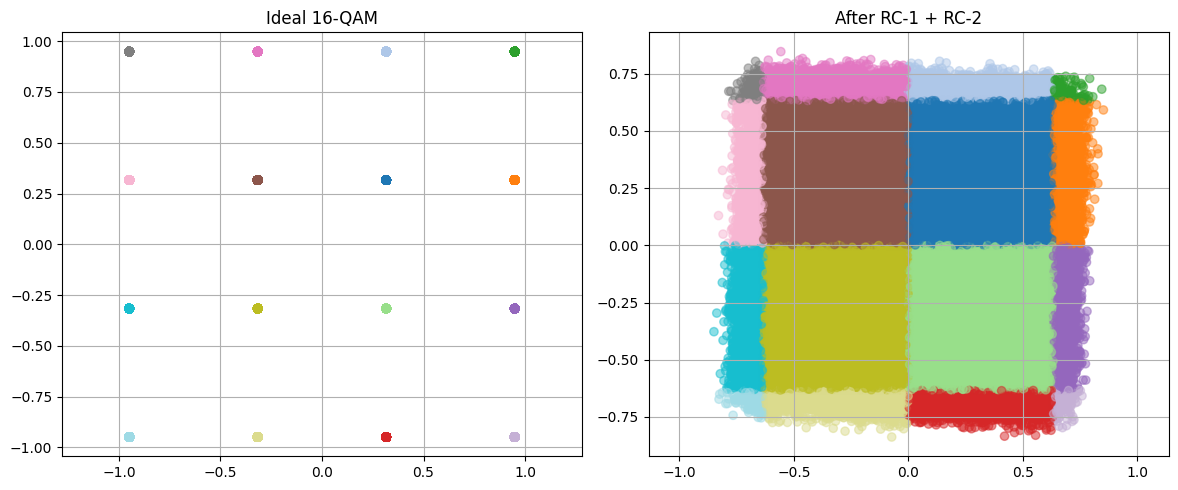

In [9]:

import tensorflow as tf

# Define teacher signals using Block 2 outputs
teacher_td = tf.transpose(x_time_ri, [0, 2, 1, 3])  # (64, 1064, 4, 2)
z_target_r = tf.reshape(z_target, [batch_size, 768, 4])  # (64, 768, 4)

# Block 5A: Train-Validation Split
val_fraction = 0.25
num_val = int(batch_size * val_fraction)  # 16 frames
num_train = batch_size - num_val  # 48 frames

# 1) Split indices
train_idx = slice(0, num_train)  # 0 … 47
val_idx = slice(num_train, batch_size)  # 48 … 63

# 2) Slice the tensors already in RAM
x_in_train = x_input_rc1[train_idx]  # (48, 1064, 8, 2)
x_in_val = x_input_rc1[val_idx]  # (16, 1064, 8, 2)

teacher_td_train = teacher_td[train_idx]  # (48, 1064, 4, 2)
teacher_td_val = teacher_td[val_idx]  # (16, 1064, 4, 2)

z_target_train = z_target_r[train_idx]  # (48, 768, 4)
z_target_val = z_target_r[val_idx]  # (16, 768, 4)

# 3) tf.data wrappers (batch == frame, so just shuffle)
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_train, teacher_td_train, z_target_train)
).shuffle(buffer_size=num_train).batch(num_train)  # one big step per epoch

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_val, teacher_td_val, z_target_val)
).batch(num_val)  # no shuffle

# 4) Diagnostics
print(" Block 5A Complete: datasets ready")
print(f"Train set : {x_in_train.shape[0]} frames")
print(f"Val   set : {x_in_val.shape[0]} frames")
print("x_in_train shape        :", x_in_train.shape)
print("teacher_td_train shape  :", teacher_td_train.shape)
print("z_target_train shape    :", z_target_train.shape)

# Block 6: Reservoir Computing Layers and Training
# 1. Define TimeFreqRC class
class TimeFreqRC(tf.keras.Model):
    """Simple reservoir with fixed Win/Wres and trainable readout + phase"""
    def __init__(self,
                 input_dim: int,
                 reservoir_size: int,
                 output_length: int,
                 leak_rate: float = 0.2,
                 dropout_rate: float = 0.0):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.output_length = output_length
        self.leak_rate = leak_rate
        self.dropout_rate = dropout_rate

        # Fixed weights
        self.Win = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                               trainable=False, name="Win")
        Wres_init = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigvals = tf.abs(tf.linalg.eigvals(Wres_init))
        self.Wres = tf.Variable(Wres_init / tf.reduce_max(eigvals),
                                trainable=False, name="Wres")

        # Trainable readout (predict 4 streams × (real, imag) = 8 values per time step)
        self.W_out = tf.Variable(tf.random.normal([reservoir_size, 8], stddev=0.01),
                                 name="W_out")

        # Per-stream phase correction (one angle per (subcarrier, stream))
        self.phase_angles = tf.Variable(tf.zeros([768, 4]), trainable=True, name="phase")

    def call(self, x, training=False):
        """
        Args:
            x : shape (B, T, A, 2) — B=batch, T=1064, A=8 antennas, 2=real/imag
        Returns:
            y_time : (B, T, 8) — predicted real/imag pairs concatenated
        """
        B, T, A, _ = x.shape
        x_flat = tf.reshape(x, [B, T, A * 2])  # 16-dim input
        h = tf.zeros([B, self.reservoir_size])  # initial state
        ta = tf.TensorArray(tf.float32, size=T)

        for t in tf.range(T):
            pre = tf.matmul(x_flat[:, t, :], self.Win) + tf.matmul(h, self.Wres)
            h = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta = ta.write(t, h)

        states = tf.transpose(ta.stack(), [1, 0, 2])  # (B, T, res_size)
        y_time = tf.matmul(states, self.W_out)  # (B, T, 8)
        return y_time

# 2. Instantiate RC-1 model & optimizer
rc1 = TimeFreqRC(input_dim=16, reservoir_size=300, output_length=1064,
                 leak_rate=0.2, dropout_rate=0.0)
optimizer = tf.keras.optimizers.Adam(1e-3)

# 3. Training step for RC-1
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # Forward
        y_ri = rc1(inputs, training=True)  # (64,1064,8)
        y_ri = tf.reshape(y_ri, [batch_size, 1064, 4, 2])  # split streams
        y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])  # (64,1064,4)

        # Loss 1: time-domain waveform
        wf_loss = tf.reduce_mean(tf.square(y_ri - teacher_td))

        # Loss 2: QAM-domain
        z_pred = tf.signal.fft(y_c)[:, :768, :]  # (64,768,4)
        phase = tf.complex(tf.cos(rc1.phase_angles),
                           tf.sin(rc1.phase_angles))  # (768,4)
        z_corr = z_pred * phase  # phase-aligned
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(z_corr - z_target_r)) +
            tf.square(tf.math.imag(z_corr - z_target_r))
        )

        total_loss = wf_loss + 0.5 * qam_loss

    grads = tape.gradient(total_loss, rc1.trainable_variables)
    optimizer.apply_gradients(zip(grads, rc1.trainable_variables))
    return total_loss, wf_loss, qam_loss

# 4. Training loop for RC-1
EPOCHS = 300
for ep in range(1, EPOCHS + 1):
    tot, wf, qam = train_step(x_input_rc1)
    if ep % 5 == 0:
        print(f"Epoch {ep:02d} | total {tot:.4f} | wf {wf:.4f} | qam {qam:.4f}")

# 5. RC-1 constellation output
def rc1_constellation(x_batch):
    y_ri = rc1(x_batch, training=False)  # (B,1064,8)
    y_ri = tf.reshape(y_ri, [-1, 1064, 4, 2])
    y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])
    z_pred = tf.signal.fft(y_c)[:, :768, :]
    phase = tf.complex(tf.cos(rc1.phase_angles),
                       tf.sin(rc1.phase_angles))  # (768,4)
    z_corr = z_pred * tf.expand_dims(phase, 0)
    return z_corr  # (B,768,4) complex

z_corr_rc1 = rc1_constellation(x_input_rc1)  # RC-1 output (64,768,4)

# 6. Residual computation
residual_z = tf.cast(z_target_r, tf.complex64) - z_corr_rc1  # (64,768,4)
residual_z_padded = tf.pad(residual_z, [[0,0],[0,296],[0,0]])  # → 1064
x_time_residual = tf.signal.ifft(residual_z_padded)  # (64,1064,4)
residual_td_ri = tf.stack([tf.math.real(x_time_residual),
                           tf.math.imag(x_time_residual)], axis=-1)  # (64,1064,4,2)

# 7. RC-2 input preparation
x_in_rc2 = residual_td_ri  # (64,1064,4,2)
mu_rc2 = tf.reduce_mean(x_in_rc2)
std_rc2 = tf.math.reduce_std(x_in_rc2) + 1e-6
x_in_rc2 = (x_in_rc2 - mu_rc2) / std_rc2

# 8. RC-2 train/validation split
x_tr2, x_val2 = x_in_rc2[train_idx], x_in_rc2[val_idx]
td_tr2, td_val2 = residual_td_ri[train_idx], residual_td_ri[val_idx]
z_tr2, z_val2 = residual_z[train_idx], residual_z[val_idx]

tr_ds2 = tf.data.Dataset.from_tensor_slices((x_tr2, td_tr2, z_tr2)).batch(x_tr2.shape[0])
val_ds2 = tf.data.Dataset.from_tensor_slices((x_val2, td_val2, z_val2)).batch(x_val2.shape[0])

# 9. RC-2 model definition
rc2 = TimeFreqRC(
    input_dim=8,  # 4 streams × 2
    reservoir_size=300,
    output_length=1064,
    leak_rate=0.30,
    dropout_rate=0.10
)

amp_gains2 = tf.Variable(tf.ones([4]), trainable=True)
lambda_qam2 = 5.0  # QAM loss weight
opt_read2 = tf.keras.optimizers.Adam(1e-3)
opt_phase2 = tf.keras.optimizers.Adam(1e-2)

@tf.function
def train_step_rc2(x_in, td_tgt, z_tgt):
    with tf.GradientTape() as tape:
        y2 = rc2(x_in, training=True)  # (B,1064,8)
        y2 = tf.reshape(y2, [-1, 1064, 4, 2])
        y2_c = tf.complex(y2[..., 0], y2[..., 1])

        # Loss-1: residual waveform
        wf_loss = tf.reduce_mean(tf.square(y2 - td_tgt))

        # Loss-2: residual constellation
        z_pred = tf.signal.fft(y2_c)[:, :768, :]
        phase2 = tf.complex(tf.cos(rc2.phase_angles),
                            tf.sin(rc2.phase_angles))
        z_corr2 = z_pred * tf.expand_dims(phase2, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 4]), z_pred.dtype)

        diff = z_corr2 - z_tgt
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(diff)) +
            tf.square(tf.math.imag(diff))
        )

        total = wf_loss + lambda_qam2 * qam_loss

    vars_all = rc2.trainable_variables + [amp_gains2]
    grads = tape.gradient(total, vars_all)
    n_read = len(rc2.trainable_variables) - 1
    opt_read2.apply_gradients(zip(grads[:n_read], vars_all[:n_read]))
    opt_phase2.apply_gradients(zip(grads[n_read:], vars_all[n_read:]))
    return total, wf_loss, qam_loss

# 10. Early-stopping loop for RC-2
best_val_qam2 = float('inf')
best_w2, wait2 = None, 0
patience2, EPOCHS2 = 8, 300

for ep in range(1, EPOCHS2 + 1):
    # Train pass
    for xb, td, zb in tr_ds2:
        tr_tot2, tr_wf2, tr_qam2 = train_step_rc2(xb, td, zb)
    # Validation pass
    for xv, tdv, zv in val_ds2:
        yv = rc2(xv, training=False)
        yv = tf.reshape(yv, [-1, 1064, 4, 2])
        yv_c = tf.complex(yv[..., 0], yv[..., 1])
        zvp = tf.signal.fft(yv_c)[:, :768, :]
        phase2_v = tf.complex(tf.cos(rc2.phase_angles),
                              tf.sin(rc2.phase_angles))
        zv_corr = zvp * tf.expand_dims(phase2_v, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 4]), zvp.dtype)
        diff_v = zv_corr - zv
        val_q2 = tf.reduce_mean(
            tf.square(tf.math.real(diff_v)) +
            tf.square(tf.math.imag(diff_v)))
    if ep % 5 == 0:
        print(f"RC-2 Ep {ep:03d} | tr_qam {tr_qam2:.4f} | val_qam {val_q2:.4f}")

    if val_q2 < best_val_qam2 - 1e-4:
        best_val_qam2, best_w2, wait2 = val_q2, rc2.get_weights(), 0
    else:
        wait2 += 1
        if wait2 >= patience2:
            print(f"RC-2 stopped @ {ep:03d}, best val_qam = {best_val_qam2:.4f}")
            rc2.set_weights(best_w2)
            break

print(" Block 6 Complete: RC-Layer 2 trained on residuals")

# 11. Final constellation (RC-1 + RC-2)
y2_final = rc2(x_in_rc2, training=False)  # (64,1064,8)
y2_final = tf.reshape(y2_final, [batch_size, 1064, 4, 2])  # (64,1064,4,2)
y2_cmplx = tf.complex(y2_final[..., 0], y2_final[..., 1])  # (64,1064,4)
z_corr_rc2 = tf.signal.fft(y2_cmplx)[:, :768, :]  # (64,768,4)

# Combined prediction
z_final = z_corr_rc1 + z_corr_rc2  # (64,768,4)
print(" Constellation combined — shape:", z_final.shape)

# Block 7: Demap, Decode, Metrics
from sionna.mapping import Demapper
from sionna.fec.ldpc.decoding import LDPC5GDecoder
import matplotlib.pyplot as plt

# 1. Setup demapper
num_bits_per_symbol = 4  # 16-QAM
demapper = Demapper(demapping_method="app",
                    constellation_type="qam",
                    num_bits_per_symbol=num_bits_per_symbol)

# 2. Soft LLRs
c_hat = demapper([z_final, no])  # (64,768,4,4)

# 3. Clip LLRs
c_hat = tf.clip_by_value(c_hat, -10.0, 10.0)

# 4. Reshape for decoder
c_hat = tf.reshape(c_hat, [batch_size, 1, 4, -1])  # (64,1,4,3072)

# 5. LDPC decoder
decoder = LDPC5GDecoder(encoder, num_iter=30, return_infobits=True)
b_hat = tf.squeeze(decoder(c_hat), axis=1)  # (64,4,1536)

# 6. Ground-truth bits
b_true = tf.reshape(b, [batch_size, 4, -1])  # (64,4,1536)

# 7. Metrics
bit_errors = tf.not_equal(b_true, b_hat)
ber = tf.reduce_mean(tf.cast(bit_errors, tf.float32))

print(" Block 7 Complete — Metrics")
print(f"BER : {ber.numpy():.6f}")

# 8. Scatter plot
def hard_labels(z):
    pts = mapper.constellation.points  # (16,) complex
    pts_ri = tf.stack([tf.math.real(pts), tf.math.imag(pts)], axis=-1)  # (16,2)
    z_ri = tf.stack([tf.math.real(z), tf.math.imag(z)], axis=-1)  # (...,2)
    z_e = tf.expand_dims(z_ri, -2)  # (...,1,2)
    pts_e = tf.reshape(pts_ri, [1, 1, 1, 16, 2])
    d2 = tf.reduce_sum(tf.square(z_e - pts_e), axis=-1)  # (...,16)
    return tf.argmin(d2, axis=-1)  # (...,)

z_true_np = z_target.numpy()
z_final_np = z_final.numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(z_true_np.real.flatten(),
              z_true_np.imag.flatten(),
              c=hard_labels(z_true_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[0].set_title("Ideal 16-QAM")
ax[0].axis('equal')
ax[0].grid(True)

ax[1].scatter(z_final_np.real.flatten(),
              z_final_np.imag.flatten(),
              c=hard_labels(z_final_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[1].set_title("After RC-1 + RC-2")
ax[1].axis('equal')
ax[1].grid(True)

plt.tight_layout()
plt.show()


Time_channel_implemantation

In [8]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"  # Helps with GPU fragmentation; comment if no GPU

import tensorflow as tf
import numpy as np
import sionna

from sionna.ofdm import ResourceGrid, OFDMModulator, OFDMDemodulator
from sionna.mimo import StreamManagement
from sionna.channel.tr38901 import CDL, AntennaArray
from sionna.channel import cir_to_time_channel, ApplyTimeChannel
from sionna.utils import ebnodb2no
from sionna.mapping import Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

sionna.config.seed = 42

# --- 1. System parameters (updated to 1 Tx, 1 Rx) ---
num_ut = 1
num_bs = 1
num_ut_ant = 1  # 1 Tx antenna
num_bs_ant = 1  # 1 Rx antenna
num_streams_per_tx = 1  # 1 stream
rx_tx_association = np.array([[1]])

sm = StreamManagement(rx_tx_association, num_streams_per_tx)

# --- 2. OFDM resource grid (unchanged) ---
rg = ResourceGrid(
    num_ofdm_symbols=14,
    fft_size=76,
    subcarrier_spacing=15e3,
    num_tx=1,
    num_streams_per_tx=num_streams_per_tx,
    cyclic_prefix_length=6,
    num_guard_carriers=[5, 6],
    dc_null=True,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[2, 11]
)

# --- 3. Antenna arrays (updated for 1 ant) ---
# --- 3. Antenna arrays (updated for 1 ant) ---
carrier_frequency = 2.6e9
ut_array = AntennaArray(1, 1, "single", "V", "38.901", carrier_frequency)  # 1 col
bs_array = AntennaArray(1, 1, "single", "V", "38.901", carrier_frequency)  # 1 col

# --- 4. 3GPP CDL channel (reduce sinusoids for memory) ---
delay_spread = 300e-9
cdl_model = "B"
speed = 10
direction = "uplink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)  # Reduced from default 20

# Diagnostics
print(" Block 1 Complete: MIMO-OFDM system & CDL channel are set up.")
print(f"FFT size              : {rg.fft_size}")
print(f"Subcarrier spacing    : {rg.subcarrier_spacing/1e3:.1f} kHz")
print(f"OFDM symbols / frame  : {rg.num_ofdm_symbols}")
print(f"Tx antennas (UT)      : {num_ut_ant}")
print(f"Rx antennas (BS)      : {num_bs_ant}")
print(f"Streams per Tx        : {num_streams_per_tx}")
print(f"Channel model         : CDL-{cdl_model},  delay spread {delay_spread*1e9:.0f} ns")
print(f"Doppler speed         : {speed} m/s (uplink)")

# --- Parameters for Block 2 ---
num_bits_per_symbol = 4  # 16-QAM
coderate = 0.5
batch_size = 16  # Reduced to avoid OOM
n = int(rg.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

binary_source = sionna.utils.BinarySource()
encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(k, n)
mapper = sionna.mapping.Mapper("qam", num_bits_per_symbol)
rg_mapper = sionna.ofdm.ResourceGridMapper(rg)

# Add OFDM modulator
modulator = OFDMModulator(rg.cyclic_prefix_length)

# --- Block 2: Transmitter ---
b = binary_source([batch_size, 1, num_streams_per_tx, k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)
z_target = x  # Ideal frequency-domain targets
x_freq = tf.cast(x_rg, tf.complex64)  # Freq domain before IFFT
x_time_no_cp = tf.signal.ifft(x_freq)  # Per-symbol IFFT, shape (16,1,1,14,76)
x_time = modulator(x_rg)  # Adds CP, shape (16,1,1, total_time=14*(76+6)=1148)
x_time = tf.reshape(x_time, [batch_size, num_ut_ant, -1])  # (16,1,1148)
x_time_ri = tf.stack([tf.math.real(x_time), tf.math.imag(x_time)], axis=-1)  # (16,1,1148,2)

print(" Block 2 Complete: Bits → LDPC → 16-QAM → OFDM grid → Modulate with CP")
print("Shape of bits (b):             ", b.shape)
print("Shape of encoded bits (c):     ", c.shape)
print("Shape of mapped QAM (x):       ", x.shape)
print("Shape of OFDM grid (x_rg):     ", x_rg.shape)
print("Shape of z_target:             ", z_target.shape)
print("Shape of x_time_ri (teacher): ", x_time_ri.shape)

# --- Block 4: Time-Domain Channel + Noise ---
sampling_rate = rg.fft_size * rg.subcarrier_spacing  # Bandwidth
l_min = 0
l_max = rg.cyclic_prefix_length
l_tot = l_max - l_min + 1
num_time_steps = rg.num_time_samples + l_tot - 1

cir = cdl(batch_size, num_time_steps, sampling_rate)  # CIR
h_time = cir_to_time_channel(sampling_rate, *cir, l_min=l_min, l_max=l_max, normalize=True)

# Time-domain channel application
time_channel = ApplyTimeChannel(rg.num_time_samples, l_tot, add_awgn=True)
ebno_db = 10.0
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
x_time_tx = tf.expand_dims(x_time, axis=1)  # (16,1,1,1148) complex
y_time = time_channel([x_time_tx, h_time, no])  # (16,1,1,1148) complex

# Demodulate to freq domain
demod = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)  # l_min=0
y_freq = demod(y_time)  # (16,1,1,14,76) complex freq per symbol

# For RC: IFFT to time domain (without CP now)
y_td_no_cp = tf.signal.ifft(y_freq)  # (16,1,1,14,76)
y_td_flat = tf.reshape(y_td_no_cp[:,0,:,:,:], [batch_size, num_bs_ant, -1])  # (16,1,1064) since 14*76=1064
y_td_flat = tf.transpose(y_td_flat, [0,2,1])  # (16,1064,1)
x_input_rc1 = tf.stack([tf.math.real(y_td_flat), tf.math.imag(y_td_flat)], axis=-1)  # (16,1064,1,2)

# Normalize
mean_rc1 = tf.reduce_mean(x_input_rc1)
std_rc1 = tf.math.reduce_std(x_input_rc1) + 1e-6
x_input_rc1 = (x_input_rc1 - mean_rc1) / std_rc1

print(" Block 4 Complete: Time channel applied (linear), demodulated, RC input from time domain")
print("h_time shape          :", h_time.shape)
print("y_freq shape          :", y_freq.shape)
print("x_input_rc1 shape     :", x_input_rc1.shape)
print(f"Mean after norm       : {tf.reduce_mean(x_input_rc1).numpy():.4f}")
print(f"Std  after norm       : {tf.math.reduce_std(x_input_rc1).numpy():.4f}")

# --- Block 5A: Train–Validation Split ---
val_fraction = 0.25
num_val = int(batch_size * val_fraction)  # 4
num_train = batch_size - num_val  # 12

train_idx = slice(0, num_train)
val_idx = slice(num_train, batch_size)

# Teacher: Use no-CP time domain
teacher_td_no_cp = tf.reshape(x_time_no_cp[:,0,:,:,:], [batch_size, -1, num_ut_ant])  # (16,1064,1)
teacher_td = tf.stack([tf.math.real(teacher_td_no_cp), tf.math.imag(teacher_td_no_cp)], axis=-1)  # (16,1064,1,2)

x_in_train = x_input_rc1[train_idx]  # (12,1064,1,2)
x_in_val = x_input_rc1[val_idx]  # (4,1064,1,2)
teacher_td_train = teacher_td[train_idx]  # (12,1064,1,2)
teacher_td_val = teacher_td[val_idx]  # (4,1064,1,2)
z_target_r = tf.reshape(z_target, [batch_size, -1, num_streams_per_tx])  # (16,768,1)
z_target_train = z_target_r[train_idx]  # (12,768,1)
z_target_val = z_target_r[val_idx]  # (4,768,1)

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_train, teacher_td_train, z_target_train)
).shuffle(num_train).batch(num_train)

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_val, teacher_td_val, z_target_val)
).batch(num_val)

print(" Block 5A Complete: datasets ready")
print(f" Train frames: {num_train}, Val frames: {num_val}")



 Block 1 Complete: MIMO-OFDM system & CDL channel are set up.
FFT size              : 76
Subcarrier spacing    : 15.0 kHz
OFDM symbols / frame  : 14
Tx antennas (UT)      : 1
Rx antennas (BS)      : 1
Streams per Tx        : 1
Channel model         : CDL-B,  delay spread 300 ns
Doppler speed         : 10 m/s (uplink)
 Block 2 Complete: Bits → LDPC → 16-QAM → OFDM grid → Modulate with CP
Shape of bits (b):              (16, 1, 1, 1536)
Shape of encoded bits (c):      (16, 1, 1, 3072)
Shape of mapped QAM (x):        (16, 1, 1, 768)
Shape of OFDM grid (x_rg):      (16, 1, 1, 14, 76)
Shape of z_target:              (16, 1, 1, 768)
Shape of x_time_ri (teacher):  (16, 1, 1148, 2)
 Block 4 Complete: Time channel applied (linear), demodulated, RC input from time domain
h_time shape          : (16, 1, 1, 1, 1, 1154, 7)
y_freq shape          : (16, 1, 1, 14, 76)
x_input_rc1 shape     : (16, 1064, 1, 2)
Mean after norm       : -0.0000
Std  after norm       : 1.0000
 Block 5A Complete: datasets re

In [9]:
# --- Block 5B: TimeFreqRC Class (ESN, updated for 1 stream) ---
class TimeFreqRC(tf.keras.Model):
    def __init__(self, input_dim, reservoir_size, output_length, leak_rate=0.2, dropout_rate=0.0):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.output_length = output_length
        self.leak_rate = leak_rate
        self.dropout_rate = dropout_rate

        # Fixed weights
        self.Win = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                               trainable=False, name="Win")
        Wres_init = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigvals = tf.abs(tf.linalg.eigvals(Wres_init))
        self.Wres = tf.Variable(Wres_init / tf.reduce_max(eigvals),
                                trainable=False, name="Wres")

        # Trainable readout (2 outputs: 1 stream x real/imag)
        self.W_out = tf.Variable(tf.random.normal([reservoir_size, 2], stddev=0.01),
                                 name="W_out")

        # Trainable phase angles (768 subcarriers x 1 stream)
        self.phase_angles = tf.Variable(tf.zeros([768, 1]), trainable=True, name="phase")

    def call(self, x, training=False):
        B, T, A, _ = x.shape
        x_flat = tf.reshape(x, [B, T, A * 2])  # Flatten to input_dim (2 for 1 Rx)
        h = tf.zeros([B, self.reservoir_size])
        ta = tf.TensorArray(tf.float32, size=T)

        for t in tf.range(T):
            pre = tf.matmul(x_flat[:, t, :], self.Win) + tf.matmul(h, self.Wres)
            h = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta = ta.write(t, h)

        states = tf.transpose(ta.stack(), [1, 0, 2])  # (B, T, reservoir_size)
        y_time = tf.matmul(states, self.W_out)  # (B, T, 2)
        return y_time

In [ ]:
# --- Block 5B: TimeFreqRC Class (ESN, updated for 1 stream) ---
class TimeFreqRC(tf.keras.Model):
    def __init__(self, input_dim, reservoir_size, output_length, leak_rate=0.2, dropout_rate=0.0):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.output_length = output_length
        self.leak_rate = leak_rate
        self.dropout_rate = dropout_rate

        # Fixed weights
        self.Win = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                               trainable=False, name="Win")
        Wres_init = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigvals = tf.abs(tf.linalg.eigvals(Wres_init))
        self.Wres = tf.Variable(Wres_init / tf.reduce_max(eigvals),
                                trainable=False, name="Wres")

        # Trainable readout (2 outputs: 1 stream x real/imag)
        self.W_out = tf.Variable(tf.random.normal([reservoir_size, 2], stddev=0.01),
                                 name="W_out")

        # Trainable phase angles (768 subcarriers x 1 stream)
        self.phase_angles = tf.Variable(tf.zeros([768, 1]), trainable=True, name="phase")

    def call(self, x, training=False):
        B, T, A, _ = x.shape
        x_flat = tf.reshape(x, [B, T, A * 2])  # Flatten to input_dim (2 for 1 Rx)
        h = tf.zeros([B, self.reservoir_size])
        ta = tf.TensorArray(tf.float32, size=T)

        for t in tf.range(T):
            pre = tf.matmul(x_flat[:, t, :], self.Win) + tf.matmul(h, self.Wres)
            h = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta = ta.write(t, h)

        states = tf.transpose(ta.stack(), [1, 0, 2])  # (B, T, reservoir_size)
        y_time = tf.matmul(states, self.W_out)  # (B, T, 2)
        return y_time

# --- Block 6: Reservoir Computing Layers and Training ---
# 1. Instantiate RC-1 model & optimizer
rc1 = TimeFreqRC(input_dim=2, reservoir_size=600, output_length=1064,
                 leak_rate=0.2, dropout_rate=0.0)
optimizer = tf.keras.optimizers.Adam(1e-3)

# 2. Training step for RC-1
@tf.function
def train_step(inputs, teacher_td, z_target_r):
    with tf.GradientTape() as tape:
        # Forward
        y_ri = rc1(inputs, training=True)  # (B,1064,2)
        y_ri = tf.reshape(y_ri, [batch_size, 1064, 1, 2])  # split streams
        y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])  # (B,1064,1)

        # Loss 1: time-domain waveform
        wf_loss = tf.reduce_mean(tf.square(y_ri - teacher_td))

        # Loss 2: QAM-domain
        z_pred = tf.signal.fft(y_c)[:, :768, :]  # (B,768,1)
        phase = tf.complex(tf.cos(rc1.phase_angles),
                           tf.sin(rc1.phase_angles))  # (768,1)
        z_corr = z_pred * phase  # phase-aligned
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(z_corr - z_target_r)) +
            tf.square(tf.math.imag(z_corr - z_target_r))
        )

        total_loss = wf_loss + 0.5 * qam_loss

    grads = tape.gradient(total_loss, rc1.trainable_variables)
    optimizer.apply_gradients(zip(grads, rc1.trainable_variables))
    return total_loss, wf_loss, qam_loss

# 3. Training loop for RC-1
EPOCHS = 300
for ep in range(1, EPOCHS + 1):
    tot, wf, qam = train_step(x_input_rc1, teacher_td, z_target_r)
    if ep % 5 == 0:
        print(f"Epoch {ep:03d} | total {tot:.4f} | wf {wf:.4f} | qam {qam:.4f}")

# 4. RC-1 constellation output
def rc1_constellation(x_batch):
    y_ri = rc1(x_batch, training=False)  # (B,1064,2)
    y_ri = tf.reshape(y_ri, [-1, 1064, 1, 2])
    y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])
    z_pred = tf.signal.fft(y_c)[:, :768, :]
    phase = tf.complex(tf.cos(rc1.phase_angles),
                       tf.sin(rc1.phase_angles))  # (768,1)
    z_corr = z_pred * tf.expand_dims(phase, 0)
    return z_corr  # (B,768,1) complex

z_corr_rc1 = rc1_constellation(x_input_rc1)  # RC-1 output (16,768,1)

# 5. Residual computation
residual_z = tf.cast(z_target_r, tf.complex64) - z_corr_rc1  # (16,768,1)
residual_z_padded = tf.pad(residual_z, [[0,0],[0,296],[0,0]])  # → 1064
x_time_residual = tf.signal.ifft(residual_z_padded)  # (16,1064,1)
residual_td_ri = tf.stack([tf.math.real(x_time_residual),
                           tf.math.imag(x_time_residual)], axis=-1)  # (16,1064,1,2)

# 6. RC-2 input preparation
x_in_rc2 = residual_td_ri  # (16,1064,1,2)
mu_rc2 = tf.reduce_mean(x_in_rc2)
std_rc2 = tf.math.reduce_std(x_in_rc2) + 1e-6
x_in_rc2 = (x_in_rc2 - mu_rc2) / std_rc2

# 7. RC-2 train/validation split
x_tr2, x_val2 = x_in_rc2[train_idx], x_in_rc2[val_idx]
td_tr2, td_val2 = residual_td_ri[train_idx], residual_td_ri[val_idx]
z_tr2, z_val2 = residual_z[train_idx], residual_z[val_idx]

tr_ds2 = tf.data.Dataset.from_tensor_slices((x_tr2, td_tr2, z_tr2)).batch(x_tr2.shape[0])
val_ds2 = tf.data.Dataset.from_tensor_slices((x_val2, td_val2, z_val2)).batch(x_val2.shape[0])

# 8. RC-2 model definition
rc2 = TimeFreqRC(
    input_dim=2,  # 1 streams × 2
    reservoir_size=300,
    output_length=1064,
    leak_rate=0.30,
    dropout_rate=0.10
)

amp_gains2 = tf.Variable(tf.ones([1]), trainable=True)
lambda_qam2 = 5.0  # QAM loss weight
opt_read2 = tf.keras.optimizers.Adam(1e-3)
opt_phase2 = tf.keras.optimizers.Adam(1e-2)

@tf.function
def train_step_rc2(x_in, td_tgt, z_tgt):
    with tf.GradientTape() as tape:
        y2 = rc2(x_in, training=True)  # (B,1064,2)
        y2 = tf.reshape(y2, [-1, 1064, 1, 2])
        y2_c = tf.complex(y2[..., 0], y2[..., 1])

        # Loss-1: residual waveform
        wf_loss = tf.reduce_mean(tf.square(y2 - td_tgt))

        # Loss-2: residual constellation
        z_pred = tf.signal.fft(y2_c)[:, :768, :]
        phase2 = tf.complex(tf.cos(rc2.phase_angles),
                            tf.sin(rc2.phase_angles))
        z_corr2 = z_pred * tf.expand_dims(phase2, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 1]), z_pred.dtype)

        diff = z_corr2 - z_tgt
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(diff)) +
            tf.square(tf.math.imag(diff))
        )

        total = wf_loss + lambda_qam2 * qam_loss

    vars_all = rc2.trainable_variables + [amp_gains2]
    grads = tape.gradient(total, vars_all)
    n_read = len(rc2.trainable_variables) - 1
    opt_read2.apply_gradients(zip(grads[:n_read], vars_all[:n_read]))
    opt_phase2.apply_gradients(zip(grads[n_read:], vars_all[n_read:]))
    return total, wf_loss, qam_loss

# 9. Early-stopping loop for RC-2
best_val_qam2 = float('inf')
best_w2, wait2 = None, 0
patience2, EPOCHS2 = 8, 300

for ep in range(1, EPOCHS2 + 1):
    # Train pass
    for xb, td, zb in tr_ds2:
        tr_tot2, tr_wf2, tr_qam2 = train_step_rc2(xb, td, zb)
    # Validation pass
    for xv, tdv, zv in val_ds2:
        yv = rc2(xv, training=False)
        yv = tf.reshape(yv, [-1, 1064, 1, 2])
        yv_c = tf.complex(yv[..., 0], yv[..., 1])
        zvp = tf.signal.fft(yv_c)[:, :768, :]
        phase2_v = tf.complex(tf.cos(rc2.phase_angles),
                              tf.sin(rc2.phase_angles))
        zv_corr = zvp * tf.expand_dims(phase2_v, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 1]), zvp.dtype)
        diff_v = zv_corr - zv
        val_q2 = tf.reduce_mean(
            tf.square(tf.math.real(diff_v)) +
            tf.square(tf.math.imag(diff_v)))
    if ep % 5 == 0:
        print(f"RC-2 Ep {ep:03d} | tr_qam {tr_qam2:.4f} | val_qam {val_q2:.4f}")

    if val_q2 < best_val_qam2 - 1e-4:
        best_val_qam2, best_w2, wait2 = val_q2, rc2.get_weights(), 0
    else:
        wait2 += 1
        if wait2 >= patience2:
            print(f"RC-2 stopped @ {ep:03d}, best val_qam = {best_val_qam2:.4f}")
            rc2.set_weights(best_w2)
            break

print(" Block 6 Complete: RC-Layer 2 trained on residuals")



Epoch 005 | total 0.5040 | wf 0.0055 | qam 0.9969
Epoch 010 | total 0.5039 | wf 0.0056 | qam 0.9966
Epoch 015 | total 0.5038 | wf 0.0056 | qam 0.9964
Epoch 020 | total 0.5038 | wf 0.0056 | qam 0.9962
Epoch 025 | total 0.5037 | wf 0.0056 | qam 0.9962
Epoch 030 | total 0.5037 | wf 0.0056 | qam 0.9961
Epoch 035 | total 0.5037 | wf 0.0056 | qam 0.9961
Epoch 040 | total 0.5036 | wf 0.0056 | qam 0.9960
Epoch 045 | total 0.5036 | wf 0.0056 | qam 0.9959
Epoch 050 | total 0.5036 | wf 0.0057 | qam 0.9958
Epoch 055 | total 0.5035 | wf 0.0057 | qam 0.9958
Epoch 060 | total 0.5035 | wf 0.0057 | qam 0.9957
Epoch 065 | total 0.5035 | wf 0.0057 | qam 0.9956
Epoch 070 | total 0.5035 | wf 0.0057 | qam 0.9956
Epoch 075 | total 0.5034 | wf 0.0057 | qam 0.9955
Epoch 080 | total 0.5034 | wf 0.0057 | qam 0.9954
Epoch 085 | total 0.5034 | wf 0.0057 | qam 0.9953
Epoch 090 | total 0.5033 | wf 0.0057 | qam 0.9952
Epoch 095 | total 0.5033 | wf 0.0057 | qam 0.9952
Epoch 100 | total 0.5033 | wf 0.0057 | qam 0.9951


 Constellation combined — shape: (16, 768, 1)
 Block 7 Complete — Metrics
BER : 0.501221


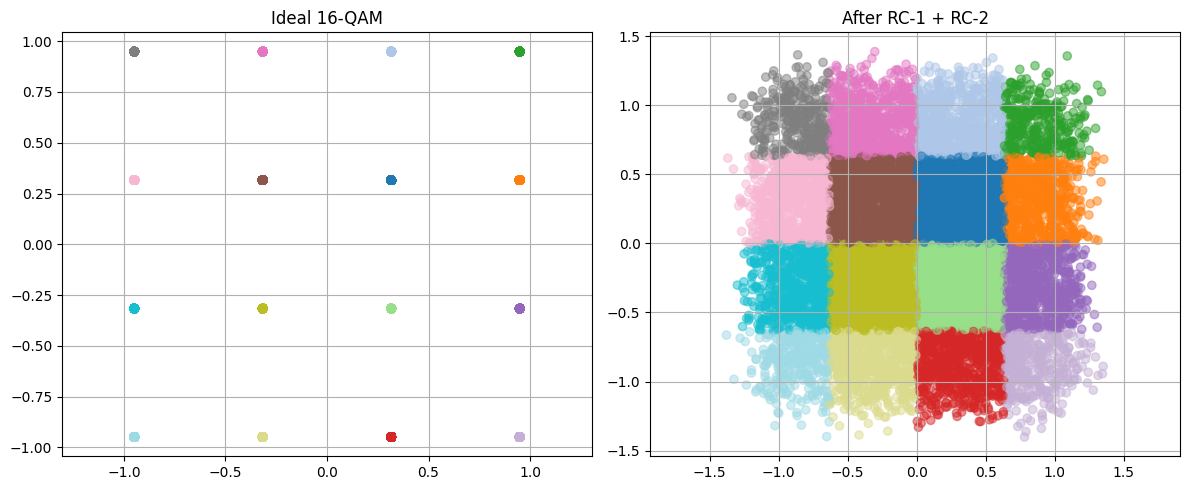

In [17]:
# 10. Final constellation (RC-1 + RC-2)
y2_final = rc2(x_in_rc2, training=False)  # (16,1064,2)
y2_final = tf.reshape(y2_final, [batch_size, 1064, 1, 2])  # (16,1064,1,2)
y2_cmplx = tf.complex(y2_final[..., 0], y2_final[..., 1])  # (16,1064,1)
z_final_rc2 = tf.signal.fft(y2_cmplx)[:, :768, :]  # (16,768,1)

phase2 = tf.complex(tf.cos(rc2.phase_angles),
                    tf.sin(rc2.phase_angles))  # (768,1)
z_corr_rc2 = z_final_rc2 * tf.expand_dims(phase2, 0) * tf.cast(tf.reshape(amp_gains2, [1, 1, 1]), z_final_rc2.dtype)

z_final = z_corr_rc1 + z_corr_rc2  # (16,768,1)
print(" Constellation combined — shape:", z_final.shape)

# Block 7: Demap, Decode, Metrics
from sionna.mapping import Demapper
from sionna.fec.ldpc.decoding import LDPC5GDecoder
import matplotlib.pyplot as plt

# 1. Setup demapper
num_bits_per_symbol = 4  # 16-QAM
demapper = Demapper(demapping_method="app",
                    constellation_type="qam",
                    num_bits_per_symbol=num_bits_per_symbol)

# 2. Soft LLRs
c_hat = demapper([z_final, no])  # (16,768,1,4)

# 3. Clip LLRs
#c_hat = tf.clip_by_value(c_hat, -10.0, 10.0)

# 4. Reshape for decoder
c_hat = tf.reshape(c_hat, [batch_size, 1, 1, -1])  # (16,1,1,3072)

# 5. LDPC decoder
decoder = LDPC5GDecoder(encoder, num_iter=30, return_infobits=True)
b_hat = tf.squeeze(decoder(c_hat), axis=1)  # (16,1,1536)

# 6. Ground-truth bits
b_true = tf.reshape(b, [batch_size, 1, -1])  # (16,1,1536)

# 7. Metrics
bit_errors = tf.not_equal(b_true, b_hat)
ber = tf.reduce_mean(tf.cast(bit_errors, tf.float32))

print(" Block 7 Complete — Metrics")
print(f"BER : {ber.numpy():.6f}")

# 8. Scatter plot
def hard_labels(z):
    pts = mapper.constellation.points  # (16,) complex
    pts_ri = tf.stack([tf.math.real(pts), tf.math.imag(pts)], axis=-1)  # (16,2)
    z_ri = tf.stack([tf.math.real(z), tf.math.imag(z)], axis=-1)  # (...,2)
    z_e = tf.expand_dims(z_ri, -2)  # (...,1,2)
    pts_e = tf.reshape(pts_ri, [1, 1, 1, 16, 2])
    d2 = tf.reduce_sum(tf.square(z_e - pts_e), axis=-1)  # (...,16)
    return tf.argmin(d2, axis=-1)  # (...)

z_true_np = z_target.numpy()
z_final_np = z_final.numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(z_true_np.real.flatten(),
              z_true_np.imag.flatten(),
              c=hard_labels(z_true_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[0].set_title("Ideal 16-QAM")
ax[0].axis('equal')
ax[0].grid(True)

ax[1].scatter(z_final_np.real.flatten(),
              z_final_np.imag.flatten(),
              c=hard_labels(z_final_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[1].set_title("After RC-1 + RC-2")
ax[1].axis('equal')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
# ============ Block 6: Reservoir Computing Layer 2 (RC-2) on Residuals ============

# 1) Compute time-domain residual after RC-1
residual_z1   = tf.cast(z_target_r, tf.complex64) - z_corr_rc1      # (64,768,4)
residual_pad1 = tf.pad(residual_z1, [[0,0],[0,296],[0,0]])         # → 1064
y_res_td      = tf.signal.ifft(residual_pad1)                       # (64,1064,4) complex
y_res_td_ri   = tf.stack([tf.math.real(y_res_td), 
                          tf.math.imag(y_res_td)], axis=-1)        # (64,1064,4,2)

# 2) Normalize & split train/val
mu2, std2       = tf.reduce_mean(y_res_td_ri), tf.math.reduce_std(y_res_td_ri) + 1e-6
x_in_rc2        = (y_res_td_ri - mu2) / std2
x_tr2, x_val2   = x_in_rc2[train_idx], x_in_rc2[val_idx]
td_tr2, td_val2 = y_res_td_ri[train_idx], y_res_td_ri[val_idx]
z_tr2, z_val2   = residual_z1[train_idx], residual_z1[val_idx]

# 3) Datasets for RC-2
tr_ds2  = tf.data.Dataset.from_tensor_slices((x_tr2, td_tr2, z_tr2)).batch(num_train)
val_ds2 = tf.data.Dataset.from_tensor_slices((x_val2, td_val2, z_val2)).batch(num_val)

# 4) Instantiate RC-2 + per-stream gains
rc2         = TimeFreqRC(input_dim=8, reservoir_size=600,
                         leak_rate=0.30, dropout_rate=0.10)
amp_gains2  = tf.Variable(tf.ones([4]), trainable=True)
lambda_qam2 = 5.0
opt2        = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step_rc2(x_t, td_t, z_t):
    B = tf.shape(x_t)[0]
    with tf.GradientTape() as tape:
        # reservoir forward
        y2     = rc2(x_t, training=True)             # (B,1064,8)
        y2     = tf.reshape(y2, [B,1064,4,2])         # (B,1064,streams,IQ)
        # waveform loss
        loss_wf = tf.reduce_mean(tf.square(y2 - td_t))
        # QAM-domain loss
        y2_c    = tf.complex(y2[...,0], y2[...,1])    # (B,1064,4)
        Zp2     = tf.signal.fft(y2_c)[:, :768, :]     # (B,768,4)
        phase2  = tf.complex(tf.cos(rc2.phase_ang), tf.sin(rc2.phase_ang))
        corr2   = Zp2 * phase2 * tf.reshape(amp_gains2, [1,1,4])
        loss_q2 = tf.reduce_mean(
                     tf.square(tf.math.real(corr2 - z_t)) +
                     tf.square(tf.math.imag(corr2 - z_t))
                  )
        loss2   = loss_wf + lambda_qam2 * loss_q2
    grads = tape.gradient(loss2, rc2.trainable_variables + [amp_gains2])
    opt2.apply_gradients(zip(grads, rc2.trainable_variables + [amp_gains2]))
    return loss2, loss_wf, loss_q2

# 5) Train RC-2 with early stopping on QAM loss
best_val2, wait2, patience2, EPOCHS2 = float('inf'), 0, 8, 300
for ep in range(1, EPOCHS2+1):
    x_b2, td_b2, z_b2 = next(iter(tr_ds2))
    tot2, wf2, q2     = train_step_rc2(x_b2, td_b2, z_b2)
    # Validation
    x_v2, td_v2, z_v2 = next(iter(val_ds2))
    Bv = tf.shape(x_v2)[0]
    yv2 = rc2(x_v2, training=False)
    yv2 = tf.reshape(yv2, [Bv,1064,4,2])
    Zv2 = tf.signal.fft(tf.complex(yv2[...,0], yv2[...,1]))[:, :768, :]
    corr_v2 = Zv2 * tf.complex(tf.cos(rc2.phase_ang), tf.sin(rc2.phase_ang)) \
              * tf.reshape(amp_gains2, [1,1,4])
    val_q2 = tf.reduce_mean(
                tf.square(tf.math.real(corr_v2 - z_v2)) +
                tf.square(tf.math.imag(corr_v2 - z_v2))
             )
    if ep % 50 == 0:
        print(f"RC-2 Ep {ep:03d} | tr_q {q2:.4f} | val_q {val_q2:.4f}")
    if val_q2 < best_val2 - 1e-4:
        best_val2, wait2 = float(val_q2), 0
        best_w2 = (rc2.get_weights(), amp_gains2.numpy())
    else:
        wait2 += 1
        if wait2 >= patience2:
            print(f"RC-2 early stop @ Ep {ep:03d}, best val_q = {best_val2:.4f}")
            rc2.set_weights(best_w2[0])
            amp_gains2.assign(best_w2[1])
            break

print("✅ Block 6 Complete: RC-2 trained")

# 6) Compute full-batch RC-2 correction
y2_full = rc2(x_in_rc2, training=False)
Bfull   = tf.shape(x_in_rc2)[0]
y2_full = tf.reshape(y2_full, [Bfull,1064,4,2])
z_corr_rc2 = tf.signal.fft(
                tf.complex(y2_full[...,0], y2_full[...,1])
             )[:, :768, :] * tf.complex(tf.cos(rc2.phase_ang),
                                       tf.sin(rc2.phase_ang)) \
               * tf.reshape(amp_gains2, [1,1,4])


ValueError: in user code:

    File "/tmp/ipykernel_465793/3440268158.py", line 33, in train_step_rc2  *
        y2     = rc2(x_t, training=True)             # (B,1064,8)
    File "/home/aoschu/anaconda3/envs/sionna_test/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filewb2vpmf_.py", line 11, in tf__call
        xf = ag__.converted_call(ag__.ld(tf).reshape, (ag__.ld(x), [ag__.ld(B), ag__.ld(T), 16]), None, fscope)

    ValueError: Exception encountered when calling layer 'time_freq_rc_11' (type TimeFreqRC).
    
    in user code:
    
        File "/tmp/ipykernel_465793/4078308058.py", line 20, in call  *
            xf  = tf.reshape(x, [B, T, 16])               # flatten antennas & IQ
    
        ValueError: Cannot reshape a tensor with 408576 elements to shape [48,1064,16] (817152 elements) for '{{node time_freq_rc_11/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](x_t, time_freq_rc_11/Reshape/shape)' with input shapes: [48,1064,4,2], [3] and with input tensors computed as partial shapes: input[1] = [48,1064,16].
    
    
    Call arguments received by layer 'time_freq_rc_11' (type TimeFreqRC):
      • x=tf.Tensor(shape=(48, 1064, 4, 2), dtype=float32)
      • training=True


✅ Block 5A Complete: datasets ready
Train set : 48 frames
Val   set : 16 frames
x_in_train shape        : (48, 1064, 8, 2)
teacher_td_train shape  : (48, 1064, 4, 2)
z_target_train shape    : (48, 768, 4)
Epoch 05 | total 0.5056 | wf 0.0057 | qam 0.9999
Epoch 10 | total 0.5053 | wf 0.0057 | qam 0.9993
Epoch 15 | total 0.5051 | wf 0.0057 | qam 0.9989
Epoch 20 | total 0.5049 | wf 0.0056 | qam 0.9986
Epoch 25 | total 0.5049 | wf 0.0056 | qam 0.9984
Epoch 30 | total 0.5048 | wf 0.0056 | qam 0.9983
Epoch 35 | total 0.5047 | wf 0.0056 | qam 0.9982
Epoch 40 | total 0.5046 | wf 0.0056 | qam 0.9980
Epoch 45 | total 0.5046 | wf 0.0056 | qam 0.9979
Epoch 50 | total 0.5045 | wf 0.0056 | qam 0.9978
Epoch 55 | total 0.5045 | wf 0.0056 | qam 0.9977
Epoch 60 | total 0.5045 | wf 0.0056 | qam 0.9976
Epoch 65 | total 0.5044 | wf 0.0056 | qam 0.9976
Epoch 70 | total 0.5044 | wf 0.0056 | qam 0.9975
Epoch 75 | total 0.5043 | wf 0.0057 | qam 0.9974
Epoch 80 | total 0.5043 | wf 0.0057 | qam 0.9973
Epoch 85 | 

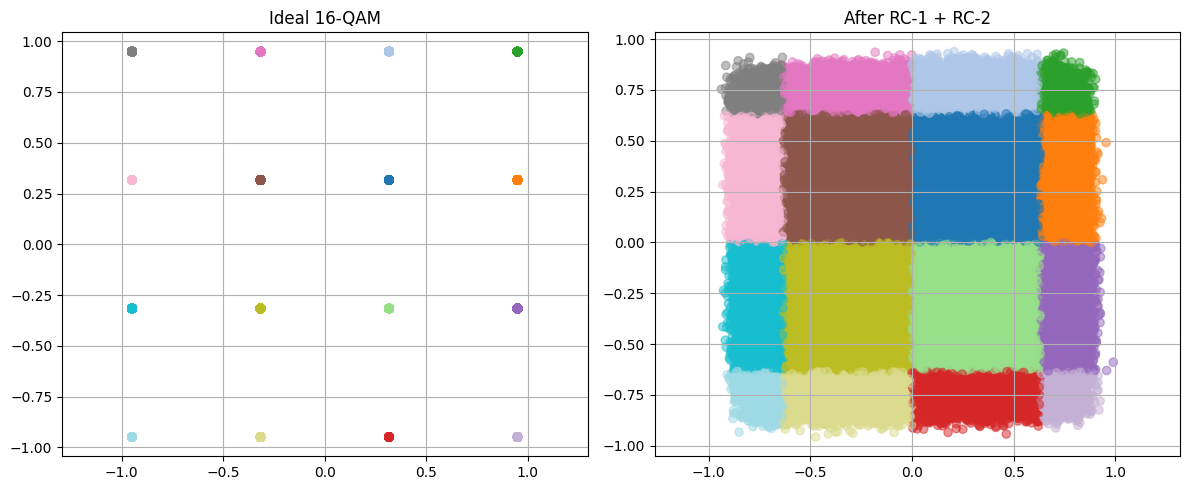

In [ ]:

import tensorflow as tf

# Define teacher signals using Block 2 outputs
teacher_td = tf.transpose(x_time_ri, [0, 2, 1, 3])  # (64, 1064, 4, 2)
z_target_r = tf.reshape(z_target, [batch_size, 768, 4])  # (64, 768, 4)

# Block 5A: Train-Validation Split
val_fraction = 0.25
num_val = int(batch_size * val_fraction)  # 16 frames
num_train = batch_size - num_val  # 48 frames

# 1) Split indices
train_idx = slice(0, num_train)  # 0 … 47
val_idx = slice(num_train, batch_size)  # 48 … 63

# 2) Slice the tensors already in RAM
x_in_train = x_input_rc1[train_idx]  # (48, 1064, 8, 2)
x_in_val = x_input_rc1[val_idx]  # (16, 1064, 8, 2)

teacher_td_train = teacher_td[train_idx]  # (48, 1064, 4, 2)
teacher_td_val = teacher_td[val_idx]  # (16, 1064, 4, 2)

z_target_train = z_target_r[train_idx]  # (48, 768, 4)
z_target_val = z_target_r[val_idx]  # (16, 768, 4)

# 3) tf.data wrappers (batch == frame, so just shuffle)
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_train, teacher_td_train, z_target_train)
).shuffle(buffer_size=num_train).batch(num_train)  # one big step per epoch

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_val, teacher_td_val, z_target_val)
).batch(num_val)  # no shuffle

# 4) Diagnostics
print("✅ Block 5A Complete: datasets ready")
print(f"Train set : {x_in_train.shape[0]} frames")
print(f"Val   set : {x_in_val.shape[0]} frames")
print("x_in_train shape        :", x_in_train.shape)
print("teacher_td_train shape  :", teacher_td_train.shape)
print("z_target_train shape    :", z_target_train.shape)

# Block 6: Reservoir Computing Layers and Training
# 1. Define TimeFreqRC class
class TimeFreqRC(tf.keras.Model):
    """Simple reservoir with fixed Win/Wres and trainable readout + phase"""
    def __init__(self,
                 input_dim: int,
                 reservoir_size: int,
                 output_length: int,
                 leak_rate: float = 0.2,
                 dropout_rate: float = 0.0):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.output_length = output_length
        self.leak_rate = leak_rate
        self.dropout_rate = dropout_rate

        # Fixed weights
        self.Win = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                               trainable=False, name="Win")
        Wres_init = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigvals = tf.abs(tf.linalg.eigvals(Wres_init))
        self.Wres = tf.Variable(Wres_init / tf.reduce_max(eigvals),
                                trainable=False, name="Wres")

        # Trainable readout (predict 4 streams × (real, imag) = 8 values per time step)
        self.W_out = tf.Variable(tf.random.normal([reservoir_size, 8], stddev=0.01),
                                 name="W_out")

        # Per-stream phase correction (one angle per (subcarrier, stream))
        self.phase_angles = tf.Variable(tf.zeros([768, 4]), trainable=True, name="phase")

    def call(self, x, training=False):
        """
        Args:
            x : shape (B, T, A, 2) — B=batch, T=1064, A=8 antennas, 2=real/imag
        Returns:
            y_time : (B, T, 8) — predicted real/imag pairs concatenated
        """
        B, T, A, _ = x.shape
        x_flat = tf.reshape(x, [B, T, A * 2])  # 16-dim input
        h = tf.zeros([B, self.reservoir_size])  # initial state
        ta = tf.TensorArray(tf.float32, size=T)

        for t in tf.range(T):
            pre = tf.matmul(x_flat[:, t, :], self.Win) + tf.matmul(h, self.Wres)
            h = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta = ta.write(t, h)

        states = tf.transpose(ta.stack(), [1, 0, 2])  # (B, T, res_size)
        y_time = tf.matmul(states, self.W_out)  # (B, T, 8)
        return y_time

# 2. Instantiate RC-1 model & optimizer
rc1 = TimeFreqRC(input_dim=16, reservoir_size=300, output_length=1064,
                 leak_rate=0.2, dropout_rate=0.0)
optimizer = tf.keras.optimizers.Adam(1e-3)

# 3. Training step for RC-1
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # Forward
        y_ri = rc1(inputs, training=True)  # (64,1064,8)
        y_ri = tf.reshape(y_ri, [batch_size, 1064, 4, 2])  # split streams
        y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])  # (64,1064,4)

        # Loss 1: time-domain waveform
        wf_loss = tf.reduce_mean(tf.square(y_ri - teacher_td))

        # Loss 2: QAM-domain
        z_pred = tf.signal.fft(y_c)[:, :768, :]  # (64,768,4)
        phase = tf.complex(tf.cos(rc1.phase_angles),
                           tf.sin(rc1.phase_angles))  # (768,4)
        z_corr = z_pred * phase  # phase-aligned
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(z_corr - z_target_r)) +
            tf.square(tf.math.imag(z_corr - z_target_r))
        )

        total_loss = wf_loss + 0.5 * qam_loss

    grads = tape.gradient(total_loss, rc1.trainable_variables)
    optimizer.apply_gradients(zip(grads, rc1.trainable_variables))
    return total_loss, wf_loss, qam_loss

# 4. Training loop for RC-1
EPOCHS = 300
for ep in range(1, EPOCHS + 1):
    tot, wf, qam = train_step(x_input_rc1)
    if ep % 5 == 0:
        print(f"Epoch {ep:02d} | total {tot:.4f} | wf {wf:.4f} | qam {qam:.4f}")

# 5. RC-1 constellation output
def rc1_constellation(x_batch):
    y_ri = rc1(x_batch, training=False)  # (B,1064,8)
    y_ri = tf.reshape(y_ri, [-1, 1064, 4, 2])
    y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])
    z_pred = tf.signal.fft(y_c)[:, :768, :]
    phase = tf.complex(tf.cos(rc1.phase_angles),
                       tf.sin(rc1.phase_angles))  # (768,4)
    z_corr = z_pred * tf.expand_dims(phase, 0)
    return z_corr  # (B,768,4) complex

z_corr_rc1 = rc1_constellation(x_input_rc1)  # RC-1 output (64,768,4)

# 6. Residual computation
residual_z = tf.cast(z_target_r, tf.complex64) - z_corr_rc1  # (64,768,4)
residual_z_padded = tf.pad(residual_z, [[0,0],[0,296],[0,0]])  # → 1064
x_time_residual = tf.signal.ifft(residual_z_padded)  # (64,1064,4)
residual_td_ri = tf.stack([tf.math.real(x_time_residual),
                           tf.math.imag(x_time_residual)], axis=-1)  # (64,1064,4,2)

# 7. RC-2 input preparation
x_in_rc2 = residual_td_ri  # (64,1064,4,2)
mu_rc2 = tf.reduce_mean(x_in_rc2)
std_rc2 = tf.math.reduce_std(x_in_rc2) + 1e-6
x_in_rc2 = (x_in_rc2 - mu_rc2) / std_rc2

# 8. RC-2 train/validation split
x_tr2, x_val2 = x_in_rc2[train_idx], x_in_rc2[val_idx]
td_tr2, td_val2 = residual_td_ri[train_idx], residual_td_ri[val_idx]
z_tr2, z_val2 = residual_z[train_idx], residual_z[val_idx]

tr_ds2 = tf.data.Dataset.from_tensor_slices((x_tr2, td_tr2, z_tr2)).batch(x_tr2.shape[0])
val_ds2 = tf.data.Dataset.from_tensor_slices((x_val2, td_val2, z_val2)).batch(x_val2.shape[0])

# 9. RC-2 model definition
rc2 = TimeFreqRC(
    input_dim=8,  # 4 streams × 2
    reservoir_size=600,
    output_length=1064,
    leak_rate=0.30,
    dropout_rate=0.10
)

amp_gains2 = tf.Variable(tf.ones([4]), trainable=True)
lambda_qam2 = 5.0  # QAM loss weight
opt_read2 = tf.keras.optimizers.Adam(1e-3)
opt_phase2 = tf.keras.optimizers.Adam(1e-2)

@tf.function
def train_step_rc2(x_in, td_tgt, z_tgt):
    with tf.GradientTape() as tape:
        y2 = rc2(x_in, training=True)  # (B,1064,8)
        y2 = tf.reshape(y2, [-1, 1064, 4, 2])
        y2_c = tf.complex(y2[..., 0], y2[..., 1])

        # Loss-1: residual waveform
        wf_loss = tf.reduce_mean(tf.square(y2 - td_tgt))

        # Loss-2: residual constellation
        z_pred = tf.signal.fft(y2_c)[:, :768, :]
        phase2 = tf.complex(tf.cos(rc2.phase_angles),
                            tf.sin(rc2.phase_angles))
        z_corr2 = z_pred * tf.expand_dims(phase2, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 4]), z_pred.dtype)

        diff = z_corr2 - z_tgt
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(diff)) +
            tf.square(tf.math.imag(diff))
        )

        total = wf_loss + lambda_qam2 * qam_loss

    vars_all = rc2.trainable_variables + [amp_gains2]
    grads = tape.gradient(total, vars_all)
    n_read = len(rc2.trainable_variables) - 1
    opt_read2.apply_gradients(zip(grads[:n_read], vars_all[:n_read]))
    opt_phase2.apply_gradients(zip(grads[n_read:], vars_all[n_read:]))
    return total, wf_loss, qam_loss

# 10. Early-stopping loop for RC-2
best_val_qam2 = float('inf')
best_w2, wait2 = None, 0
patience2, EPOCHS2 = 8, 300

for ep in range(1, EPOCHS2 + 1):
    # Train pass
    for xb, td, zb in tr_ds2:
        tr_tot2, tr_wf2, tr_qam2 = train_step_rc2(xb, td, zb)
    # Validation pass
    for xv, tdv, zv in val_ds2:
        yv = rc2(xv, training=False)
        yv = tf.reshape(yv, [-1, 1064, 4, 2])
        yv_c = tf.complex(yv[..., 0], yv[..., 1])
        zvp = tf.signal.fft(yv_c)[:, :768, :]
        phase2_v = tf.complex(tf.cos(rc2.phase_angles),
                              tf.sin(rc2.phase_angles))
        zv_corr = zvp * tf.expand_dims(phase2_v, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 4]), zvp.dtype)
        diff_v = zv_corr - zv
        val_q2 = tf.reduce_mean(
            tf.square(tf.math.real(diff_v)) +
            tf.square(tf.math.imag(diff_v)))
    if ep % 5 == 0:
        print(f"RC-2 Ep {ep:03d} | tr_qam {tr_qam2:.4f} | val_qam {val_q2:.4f}")

    if val_q2 < best_val_qam2 - 1e-4:
        best_val_qam2, best_w2, wait2 = val_q2, rc2.get_weights(), 0
    else:
        wait2 += 1
        if wait2 >= patience2:
            print(f"RC-2 stopped @ {ep:03d}, best val_qam = {best_val_qam2:.4f}")
            rc2.set_weights(best_w2)
            break

print("✅ Block 6 Complete: RC-Layer 2 trained on residuals")

# 11. Final constellation (RC-1 + RC-2)
y2_final = rc2(x_in_rc2, training=False)  # (64,1064,8)
y2_final = tf.reshape(y2_final, [batch_size, 1064, 4, 2])  # (64,1064,4,2)
y2_cmplx = tf.complex(y2_final[..., 0], y2_final[..., 1])  # (64,1064,4)
z_corr_rc2 = tf.signal.fft(y2_cmplx)[:, :768, :]  # (64,768,4)

# Combined prediction
z_final = z_corr_rc1 + z_corr_rc2  # (64,768,4)
print("✅ Constellation combined — shape:", z_final.shape)

# Block 7: Demap, Decode, Metrics
from sionna.mapping import Demapper
from sionna.fec.ldpc.decoding import LDPC5GDecoder
import matplotlib.pyplot as plt

# 1. Setup demapper
num_bits_per_symbol = 4  # 16-QAM
demapper = Demapper(demapping_method="app",
                    constellation_type="qam",
                    num_bits_per_symbol=num_bits_per_symbol)

# 2. Soft LLRs
c_hat = demapper([z_final, no])  # (64,768,4,4)

# 3. Clip LLRs
c_hat = tf.clip_by_value(c_hat, -10.0, 10.0)

# 4. Reshape for decoder
c_hat = tf.reshape(c_hat, [batch_size, 1, 4, -1])  # (64,1,4,3072)

# 5. LDPC decoder
decoder = LDPC5GDecoder(encoder, num_iter=30, return_infobits=True)
b_hat = tf.squeeze(decoder(c_hat), axis=1)  # (64,4,1536)

# 6. Ground-truth bits
b_true = tf.reshape(b, [batch_size, 4, -1])  # (64,4,1536)

# 7. Metrics
bit_errors = tf.not_equal(b_true, b_hat)
ber = tf.reduce_mean(tf.cast(bit_errors, tf.float32))

print("✅ Block 7 Complete — Metrics")
print(f"BER : {ber.numpy():.6f}")

# 8. Scatter plot
def hard_labels(z):
    pts = mapper.constellation.points  # (16,) complex
    pts_ri = tf.stack([tf.math.real(pts), tf.math.imag(pts)], axis=-1)  # (16,2)
    z_ri = tf.stack([tf.math.real(z), tf.math.imag(z)], axis=-1)  # (...,2)
    z_e = tf.expand_dims(z_ri, -2)  # (...,1,2)
    pts_e = tf.reshape(pts_ri, [1, 1, 1, 16, 2])
    d2 = tf.reduce_sum(tf.square(z_e - pts_e), axis=-1)  # (...,16)
    return tf.argmin(d2, axis=-1)  # (...,)

z_true_np = z_target.numpy()
z_final_np = z_final.numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(z_true_np.real.flatten(),
              z_true_np.imag.flatten(),
              c=hard_labels(z_true_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[0].set_title("Ideal 16-QAM")
ax[0].axis('equal')
ax[0].grid(True)

ax[1].scatter(z_final_np.real.flatten(),
              z_final_np.imag.flatten(),
              c=hard_labels(z_final_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[1].set_title("After RC-1 + RC-2")
ax[1].axis('equal')
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:

import tensorflow as tf

# Block 6: Reservoir Computing Layers and Training
# 1. Define TimeFreqRC class
class TimeFreqRC(tf.keras.Model):
    """Simple reservoir with fixed Win/Wres and trainable readout + phase"""
    def __init__(self,
                 input_dim: int,
                 reservoir_size: int,
                 output_length: int,
                 leak_rate: float = 0.2,
                 dropout_rate: float = 0.0):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.output_length = output_length
        self.leak_rate = leak_rate
        self.dropout_rate = dropout_rate

        # Fixed weights
        self.Win = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                               trainable=False, name="Win")
        Wres_init = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigvals = tf.abs(tf.linalg.eigvals(Wres_init))
        self.Wres = tf.Variable(Wres_init / tf.reduce_max(eigvals),
                                trainable=False, name="Wres")

        # Trainable readout (predict 4 streams × (real, imag) = 8 values per time step)
        self.W_out = tf.Variable(tf.random.normal([reservoir_size, 8], stddev=0.01),
                                 name="W_out")

        # Per-stream phase correction (one angle per (subcarrier, stream))
        self.phase_angles = tf.Variable(tf.zeros([768, 4]), trainable=True, name="phase")

    def call(self, x, training=False):
        """
        Args:
            x : shape (B, T, A, 2) — B=batch, T=1064, A=8 antennas, 2=real/imag
        Returns:
            y_time : (B, T, 8) — predicted real/imag pairs concatenated
        """
        B, T, A, _ = x.shape
        x_flat = tf.reshape(x, [B, T, A * 2])  # 16-dim input
        h = tf.zeros([B, self.reservoir_size])  # initial state
        ta = tf.TensorArray(tf.float32, size=T)

        for t in tf.range(T):
            pre = tf.matmul(x_flat[:, t, :], self.Win) + tf.matmul(h, self.Wres)
            h = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta = ta.write(t, h)

        states = tf.transpose(ta.stack(), [1, 0, 2])  # (B, T, res_size)
        y_time = tf.matmul(states, self.W_out)  # (B, T, 8)
        return y_time

# 2. Instantiate RC-1 model & optimizer
rc1 = TimeFreqRC(input_dim=16, reservoir_size=300, output_length=1064,
                 leak_rate=0.2, dropout_rate=0.0)
optimizer = tf.keras.optimizers.Adam(1e-3)
amp_gains = tf.Variable(tf.ones([4]), trainable=True)  # Fix for RC-1

# 3. Training step for RC-1
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # Forward
        y_ri = rc1(inputs, training=True)  # (64,1064,8)
        y_ri = tf.reshape(y_ri, [batch_size, 1064, 4, 2])  # split streams
        y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])  # (64,1064,4)

        # Loss 1: time-domain waveform
        wf_loss = tf.reduce_mean(tf.square(y_ri - teacher_td))

        # Loss 2: QAM-domain
        z_pred = tf.signal.fft(y_c)[:, :768, :]  # (64,768,4)
        phase = tf.complex(tf.cos(rc1.phase_angles),
                           tf.sin(rc1.phase_angles))  # (768,4)
        z_corr = z_pred * phase * tf.cast(tf.reshape(amp_gains, [1, 1, 4]), z_pred.dtype)
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(z_corr - z_target_r)) +
            tf.square(tf.math.imag(z_corr - z_target_r))
        )

        total_loss = wf_loss + 0.5 * qam_loss

    grads = tape.gradient(total_loss, rc1.trainable_variables + [amp_gains])
    optimizer.apply_gradients(zip(grads, rc1.trainable_variables + [amp_gains]))
    return total_loss, wf_loss, qam_loss

# 4. Training loop for RC-1
EPOCHS = 300
for ep in range(1, EPOCHS + 1):
    tot, wf, qam = train_step(x_input_rc1)
    if ep % 5 == 0:
        print(f"Epoch {ep:02d} | total {tot:.4f} | wf {wf:.4f} | qam {qam:.4f}")

# 5. RC-1 constellation output
def rc1_constellation(x_batch):
    y_ri = rc1(x_batch, training=False)  # (B,1064,8)
    y_ri = tf.reshape(y_ri, [-1, 1064, 4, 2])
    y_c = tf.complex(y_ri[..., 0], y_ri[..., 1])
    z_pred = tf.signal.fft(y_c)[:, :768, :]
    phase = tf.complex(tf.cos(rc1.phase_angles),
                       tf.sin(rc1.phase_angles))  # (768,4)
    z_corr = z_pred * tf.expand_dims(phase, 0) * \
             tf.cast(tf.reshape(amp_gains, [1, 1, 4]), z_pred.dtype)
    return z_corr  # (B,768,4) complex

z_corr_rc1 = rc1_constellation(x_input_rc1)  # RC-1 output (64,768,4)

# RC-2 Implementation
# 1) Residual (frequency) & residual (time) as training targets
residual_z = tf.cast(z_target_r, tf.complex64) - z_corr_rc1  # (64,768,4)
residual_z_padded = tf.pad(residual_z, [[0, 0], [0, 296], [0, 0]])  # → 1064
x_time_residual = tf.signal.ifft(residual_z_padded)  # (64,1064,4)
residual_td_ri = tf.stack([tf.math.real(x_time_residual),
                           tf.math.imag(x_time_residual)], axis=-1)  # (64,1064,4,2)

# 2) RC-2 input = residual time waveform (normalised)
x_in_rc2 = residual_td_ri  # already (64,1064,4,2)
mu_rc2 = tf.reduce_mean(x_in_rc2)
std_rc2 = tf.math.reduce_std(x_in_rc2) + 1e-6
x_in_rc2 = (x_in_rc2 - mu_rc2) / std_rc2

# 3) Same train/val indices as Block 5A
x_tr2, x_val2 = x_in_rc2[train_idx], x_in_rc2[val_idx]
td_tr2, td_val2 = residual_td_ri[train_idx], residual_td_ri[val_idx]
z_tr2, z_val2 = residual_z[train_idx], residual_z[val_idx]

tr_ds2 = tf.data.Dataset.from_tensor_slices((x_tr2, td_tr2, z_tr2)).batch(x_tr2.shape[0])
val_ds2 = tf.data.Dataset.from_tensor_slices((x_val2, td_val2, z_val2)).batch(x_val2.shape[0])

# 4) RC-Layer 2 definition
rc2 = TimeFreqRC(
    input_dim=8,  # 4 streams × 2
    reservoir_size=600,
    output_length=1064,
    leak_rate=0.30,
    dropout_rate=0.10
)

amp_gains2 = tf.Variable(tf.ones([4]), trainable=True)
lambda_qam2 = 5.0
opt_read2 = tf.keras.optimizers.Adam(1e-3)
opt_phase2 = tf.keras.optimizers.Adam(1e-2)

@tf.function
def train_step_rc2(x_in, td_tgt, z_tgt):
    with tf.GradientTape() as tape:
        y2 = rc2(x_in, training=True)  # (B,1064,8)
        y2 = tf.reshape(y2, [-1, 1064, 4, 2])
        y2_c = tf.complex(y2[..., 0], y2[..., 1])

        # Loss-1: residual waveform
        wf_loss = tf.reduce_mean(tf.square(y2 - td_tgt))

        # Loss-2: residual constellation
        z_pred = tf.signal.fft(y2_c)[:, :768, :]
        phase2 = tf.complex(tf.cos(rc2.phase_angles),
                            tf.sin(rc2.phase_angles))
        z_corr2 = z_pred * tf.expand_dims(phase2, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 4]), z_pred.dtype)

        diff = z_corr2 - z_tgt
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(diff)) +
            tf.square(tf.math.imag(diff)))
        )

        total = wf_loss + lambda_qam2 * qam_loss

    grads = tape.gradient(total, rc2.trainable_variables + [amp_gains2])
    n_read = len(rc2.trainable_variables) - 1
    opt_read2.apply_gradients(zip(grads[:n_read], vars_all[:n_read]))
    opt_phase2.apply_gradients(zip(grads[n_read:], vars_all[n_read:]]))
    return total, wf_loss, qam_loss

# 5) Early-stopping loop
best_val_qam2 = float('inf')
best_w2, wait2 = None, 0
patience2, EPOCHS2 = 8, 300

for ep in range(1, EPOCHS2 + 1):
    # Train pass
    for xb, td, zb in tr_ds2:
        tr_tot2, tr_wf2, tr_qam2 = train_step_rc2(xb, td, zb)
    # Validation pass
    for xv, tdv, zv in val_ds2:
        yv = rc2(xv, training=False)
        yv = tf.reshape(yv, [-1, 1064, 4, 2])
        yv_c = tf.complex(yv[..., 0], yv[..., 1])
        zvp = tf.signal.fft(yv_c)[:, :768, :]
        phase2_v = tf.complex(tf.cos(rc2.phase_angles),
                              tf.sin(rc2.phase_angles))
        zv_corr = zvp * tf.expand_dims(phase2_v, 0) * \
                  tf.cast(tf.reshape(amp_gains2, [1, 1, 4]), zvp.dtype)
        diff_v = zv_corr - zv
        val_q2 = tf.reduce_mean(
            tf.square(tf.math.real(diff_v)) +
            tf.square(tf.math.imag(diff_v)))
    if ep % 5 == 0:
        print(f"RC-2 Ep {ep:03d} | tr_qam {tr_qam2:.4f} | val_qam {val_q2:.4f}")

    if val_q2 < best_val_qam2 - 1e-4:
        best_val_qam2, best_w2, wait2 = val_q2, rc2.get_weights(), 0
    else:
        wait2 += 1
        if wait2 >= patience2:
            print(f"RC-2 stopped @ {ep:03d}, best val_qam = {best_val_qam2:.6f}")
            rc2.set_weights(best_w2)
            break

print("✅ Block 6 Complete: RC-Layer 2 trained on residuals")

# FINAL CONSTELLATION (RC-1 + RC-2)
y2_final = rc2(x_in_rc2, training=False)  # (64,1064,8)
y2_final = tf.reshape(y2_final, [batch_size, 1064, 4, 2])  # (64,1064,4,2)
y2_cmplx = tf.complex(y2_final[..., 0], y2_final[..., 1])  # (64,1064,4)
z_corr_rc2 = tf.signal.fft(y2_cmplx)[:, :768, :]  # (64,768,4)

# Combined prediction
z_final = z_corr_rc1 + z_corr_rc2  # ready for demapper
print("✅ Constellation combined — shape:", z_final.shape)

# Block 7: Demap, Decode, Metrics
from sionna.mapping import Demapper
from sionna.fec.ldpc.decoding import LDPC5GDecoder
import matplotlib.pyplot as plt

# 1. Setup demapper
num_bits_per_symbol = 4  # 16-QAM
demapper = Demapper(demapping_method="app",
                    constellation_type="qam",
                    num_bits_per_symbol=num_bits_per_symbol)

# 2. Soft LLRs
c_hat = demapper([z_final, no])  # (64,768,4,4)

# 3. Clip LLRs
c_hat = tf.clip_by_value(c_hat, -10.0, 10.0)

# 4. Reshape for decoder
c_hat = tf.reshape(c_hat, [batch_size, 1, 4, -1])  # (64,1,4,3072)

# 5. LDPC decoder
decoder = LDPC5GDecoder(encoder, num_iter=30, return_infobits=True)
b_hat = tf.squeeze(decoder(c_hat), axis=1)  # (64,4,1536)

# 6. Ground-truth bits
b_true = tf.reshape(b, [batch_size, 4, -1])  # (64,4,1536)

# 7. Metrics
bit_errors = tf.not_equal(b_true, b_hat)
ber = tf.reduce_mean(tf.cast(bit_errors, tf.float32))

print("✅ Block 7 Complete — Metrics")
print(f"BER: {ber.numpy():.6f}")

# 8. Scatter plot
def hard_labels(z):
    pts = mapper.constellation.points  # (16,) complex
    pts_ri = tf.stack([tf.math.real(pts), tf.math.imag(pts)], axis=-1)  # (16,2)
    z_ri = tf.stack([tf.math.real(z), tf.math.imag(z)], axis=-1)  # (...,2)
    z_e = tf.expand_dims(z_ri, -2)  # (...,1,2)
    pts_e = tf.reshape(pts_ri, [1, 1, 1, 16, 2])
    d2 = tf.reduce_sum(tf.square(z_e - pts_e), axis=-1)  # (...,16)
    return tf.argmin(d2, axis=-1)  # (...,)

z_true_np = z_target.numpy()
z_final_np = z_final.numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(z_true_np.real.flatten(),
              z_true_np.imag.flatten(),
              c=hard_labels(z_true_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[0].set_title("Ideal 16-QAM")
ax[0].axis('equal')
ax[0].grid(True)

ax[1].scatter(z_final_np.real.flatten(),
              z_final_np.imag.flatten(),
              c=hard_labels(z_final_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[1].set_title("After RC-1 + RC-2")
ax[1].axis('equal')
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [17]:
x_time_ri = tf.stack([tf.math.real(x_time), tf.math.imag(x_time)], axis=-1)  # (64,4,1064,2)
z_target = x  # (64,1,4,768) complex symbols
import tensorflow as tf

# Define teacher signals using Block 2 outputs
teacher_td = tf.transpose(x_time_ri, [0, 2, 1, 3])  # (64, 1064, 4, 2)
z_target_r = tf.reshape(z_target, [batch_size, 768, 4])  # (64, 768, 4)

In [18]:
# Block 5A: Train-Validation Split
val_fraction = 0.25
num_val = int(batch_size * val_fraction)  # 16 frames
num_train = batch_size - num_val  # 48 frames

# 1) Split indices
train_idx = slice(0, num_train)  # 0 … 47
val_idx = slice(num_train, batch_size)  # 48 … 63

# 2) Slice the tensors already in RAM
x_in_train = x_input_rc1[train_idx]  # (48, 1064, 8, 2)
x_in_val = x_input_rc1[val_idx]  # (16, 1064, 8, 2)

teacher_td_train = teacher_td[train_idx]  # (48, 1064, 4, 2)
teacher_td_val = teacher_td[val_idx]  # (16, 1064, 4, 2)

z_target_train = z_target_r[train_idx]  # (48, 768, 4)
z_target_val = z_target_r[val_idx]  # (16, 768, 4)

# 3) tf.data wrappers (batch == frame, so just shuffle)
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_train, teacher_td_train, z_target_train)
).shuffle(buffer_size=num_train).batch(num_train)  # one big step per epoch

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_in_val, teacher_td_val, z_target_val)
).batch(num_val)  # no shuffle

# 4) Diagnostics
print("✅ Block 5A Complete: datasets ready")
print(f"Train set : {x_in_train.shape[0]} frames")
print(f"Val   set : {x_in_val.shape[0]} frames")
print("x_in_train shape        :", x_in_train.shape)
print("teacher_td_train shape  :", teacher_td_train.shape)
print("z_target_train shape    :", z_target_train.shape)

✅ Block 5A Complete: datasets ready
Train set : 48 frames
Val   set : 16 frames
x_in_train shape        : (48, 1064, 8, 2)
teacher_td_train shape  : (48, 1064, 4, 2)
z_target_train shape    : (48, 768, 4)


In [19]:


# ----------------------------------------------------------------
import tensorflow as tf

class TimeFreqRC(tf.keras.Model):
    """Simple reservoir with fixed Win/Wres and trainable readout + phase"""
    def __init__(self,
                 input_dim: int,
                 reservoir_size: int,
                 output_length: int,
                 leak_rate: float = 0.2,
                 dropout_rate: float = 0.0):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.output_length  = output_length
        self.leak_rate      = leak_rate
        self.dropout_rate   = dropout_rate

        # Fixed weights
        self.Win = tf.Variable(tf.random.normal([input_dim, reservoir_size]) * 0.1,
                               trainable=False, name="Win")
        Wres_init = tf.random.normal([reservoir_size, reservoir_size]) * 0.1
        eigvals   = tf.abs(tf.linalg.eigvals(Wres_init))
        self.Wres = tf.Variable(Wres_init / tf.reduce_max(eigvals),
                                trainable=False, name="Wres")

        # Trainable readout (predict 4 streams × (real, imag) = 8 values per time step)
        self.W_out = tf.Variable(tf.random.normal([reservoir_size, 8], stddev=0.01),
                                 name="W_out")

        # Per-stream phase correction (one angle per (subcarrier, stream))
        self.phase_angles = tf.Variable(tf.zeros([768, 4]), trainable=True, name="phase")

    def call(self, x, training=False):
        """
        Args:
            x : shape (B, T, A, 2)  — B=batch, T=1064, A=8 antennas, 2=real/imag
        Returns:
            y_time : (B, T, 8)  — predicted real/imag pairs concatenated
        """
        B, T, A, _ = x.shape
        x_flat = tf.reshape(x, [B, T, A * 2])        # 16-dim input
        h      = tf.zeros([B, self.reservoir_size])  # initial state
        ta     = tf.TensorArray(tf.float32, size=T)

        for t in tf.range(T):
            pre = tf.matmul(x_flat[:, t, :], self.Win) + tf.matmul(h, self.Wres)
            h   = (1 - self.leak_rate) * h + self.leak_rate * tf.math.tanh(pre)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
            ta  = ta.write(t, h)

        states = tf.transpose(ta.stack(), [1, 0, 2])    # (B, T, res_size)
        y_time = tf.matmul(states, self.W_out)          # (B, T, 8)
        return y_time

# ----------------------------------------------------------------
# 1. Instantiate model & optimiser
rc1 = TimeFreqRC(input_dim=16, reservoir_size=300, output_length=1064,
                 leak_rate=0.2, dropout_rate=0.0)
optimizer = tf.keras.optimizers.Adam(1e-3)

# 2. Helper tensors
teacher_td = tf.transpose(x_time_ri, [0, 2, 1, 3])   # (64,1064,4,2)
z_target_r = tf.reshape(z_target, [batch_size, 768, 4])  # (64,768,4)

# 3. Training step
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # Forward
        y_ri = rc1(inputs, training=True)                   # (64,1064,8)
        y_ri = tf.reshape(y_ri, [batch_size, 1064, 4, 2])   # split streams
        y_c  = tf.complex(y_ri[..., 0], y_ri[..., 1])       # (64,1064,4)

        # --- Loss 1: time-domain waveform -----------------
        wf_loss = tf.reduce_mean(tf.square(y_ri - teacher_td))

        # --- Loss 2: QAM-domain ---------------------------
        z_pred  = tf.signal.fft(y_c)[:, :768, :]            # (64,768,4)
        phase   = tf.complex(tf.cos(rc1.phase_angles),
                             tf.sin(rc1.phase_angles))      # (768,4)
        z_corr  = z_pred * phase                            # phase-aligned
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(z_corr - z_target_r)) +
            tf.square(tf.math.imag(z_corr - z_target_r))
        )

        total_loss = wf_loss + 0.5 * qam_loss

    grads = tape.gradient(total_loss, rc1.trainable_variables)
    optimizer.apply_gradients(zip(grads, rc1.trainable_variables))
    return total_loss, wf_loss, qam_loss

# 4. Training loop
EPOCHS = 300          
for ep in range(1, EPOCHS + 1):
    tot, wf, qam = train_step(x_input_rc1)
    if ep % 5 == 0:
        print(f"Epoch {ep:02d} | total {tot:.4f} | wf {wf:.4f} | qam {qam:.4f}")


Epoch 05 | total 0.5057 | wf 0.0057 | qam 1.0000
Epoch 10 | total 0.5053 | wf 0.0057 | qam 0.9992
Epoch 15 | total 0.5051 | wf 0.0057 | qam 0.9989
Epoch 20 | total 0.5050 | wf 0.0056 | qam 0.9986
Epoch 25 | total 0.5049 | wf 0.0056 | qam 0.9985
Epoch 30 | total 0.5048 | wf 0.0056 | qam 0.9983
Epoch 35 | total 0.5047 | wf 0.0056 | qam 0.9982
Epoch 40 | total 0.5047 | wf 0.0056 | qam 0.9981
Epoch 45 | total 0.5046 | wf 0.0056 | qam 0.9980
Epoch 50 | total 0.5046 | wf 0.0056 | qam 0.9979
Epoch 55 | total 0.5046 | wf 0.0056 | qam 0.9978
Epoch 60 | total 0.5045 | wf 0.0056 | qam 0.9978
Epoch 65 | total 0.5045 | wf 0.0056 | qam 0.9977
Epoch 70 | total 0.5044 | wf 0.0056 | qam 0.9976
Epoch 75 | total 0.5044 | wf 0.0056 | qam 0.9975
Epoch 80 | total 0.5044 | wf 0.0056 | qam 0.9975
Epoch 85 | total 0.5043 | wf 0.0057 | qam 0.9974
Epoch 90 | total 0.5043 | wf 0.0057 | qam 0.9973
Epoch 95 | total 0.5043 | wf 0.0057 | qam 0.9972
Epoch 100 | total 0.5042 | wf 0.0057 | qam 0.9972
Epoch 105 | total 0

In [20]:
# ============ Block 6 (fixed): Residual Generation & RC-Layer 2 ============

# ------------------------------------------------------------------
# 0)  Helper – RC-1 constellation once, so we keep it for later combo
def rc1_constellation(x_batch):
    y_ri   = rc1(x_batch, training=False)                  # (B,1064,8)
    y_ri   = tf.reshape(y_ri, [-1, 1064, 4, 2])
    y_c    = tf.complex(y_ri[...,0], y_ri[...,1])
    z_pred = tf.signal.fft(y_c)[:, :768, :]
    phase  = tf.complex(tf.cos(rc1.phase_angles),
                        tf.sin(rc1.phase_angles))          # (768,4)
    z_corr = z_pred * tf.expand_dims(phase, 0) * \
             tf.cast(tf.reshape(amp_gains, [1,1,4]), z_pred.dtype)
    return z_corr                                          # (B,768,4) complex

z_corr_rc1 = rc1_constellation(x_input_rc1)                # RC-1 output (64,768,4)

# ------------------------------------------------------------------
# 1)  Residual (frequency) & residual (time) as training targets
residual_z  = tf.cast(z_target_r, tf.complex64) - z_corr_rc1     # (64,768,4)
residual_z_padded = tf.pad(residual_z, [[0,0],[0,296],[0,0]])    # → 1064
x_time_residual   = tf.signal.ifft(residual_z_padded)            # (64,1064,4)
residual_td_ri    = tf.stack([tf.math.real(x_time_residual),
                              tf.math.imag(x_time_residual)], axis=-1)  # (64,1064,4,2)

# ------------------------------------------------------------------
# 2)  RC-2 input = residual time waveform (normalised)
x_in_rc2 = residual_td_ri                                   # already (64,1064,4,2)
mu_rc2  = tf.reduce_mean(x_in_rc2)
std_rc2 = tf.math.reduce_std(x_in_rc2) + 1e-6
x_in_rc2 = (x_in_rc2 - mu_rc2) / std_rc2

# ------------------------------------------------------------------
# 3)  Same train/val indices as Block 5A
x_tr2, x_val2 = x_in_rc2[train_idx], x_in_rc2[val_idx]
td_tr2, td_val2 = residual_td_ri[train_idx], residual_td_ri[val_idx]
z_tr2, z_val2   = residual_z[train_idx],  residual_z[val_idx]

tr_ds2 = tf.data.Dataset.from_tensor_slices((x_tr2, td_tr2, z_tr2)).batch(x_tr2.shape[0])
val_ds2 = tf.data.Dataset.from_tensor_slices((x_val2, td_val2, z_val2)).batch(x_val2.shape[0])

# ------------------------------------------------------------------
# 4)  RC-Layer 2 definition
rc2 = TimeFreqRC(
    input_dim      = 8,        # 4 streams × 2
    reservoir_size = 600,
    output_length  = 1064,
    leak_rate      = 0.30,
    dropout_rate   = 0.10
)

amp_gains2  = tf.Variable(tf.ones([4]), trainable=True)
lambda_qam2 = 5.0
opt_read2   = tf.keras.optimizers.Adam(1e-3)
opt_phase2  = tf.keras.optimizers.Adam(1e-2)

@tf.function
def train_step_rc2(x_in, td_tgt, z_tgt):
    with tf.GradientTape() as tape:
        y2   = rc2(x_in, training=True)                 # (B,1064,8)
        y2   = tf.reshape(y2, [-1,1064,4,2])
        y2_c = tf.complex(y2[...,0], y2[...,1])

        # ---- Loss-1: residual waveform -----------------
        wf_loss = tf.reduce_mean(tf.square(y2 - td_tgt))

        # ---- Loss-2: residual constellation ------------
        z_pred  = tf.signal.fft(y2_c)[:, :768, :]
        phase2  = tf.complex(tf.cos(rc2.phase_angles),
                             tf.sin(rc2.phase_angles))
        z_corr2 = z_pred * tf.expand_dims(phase2,0) * \
                  tf.cast(tf.reshape(amp_gains2,[1,1,4]), z_pred.dtype)

        diff    = z_corr2 - z_tgt
        qam_loss = tf.reduce_mean(
            tf.square(tf.math.real(diff)) +
            tf.square(tf.math.imag(diff))
        )

        total = wf_loss + lambda_qam2 * qam_loss

    vars_all = rc2.trainable_variables + [amp_gains2]
    grads    = tape.gradient(total, vars_all)
    n_read   = len(rc2.trainable_variables) - 1
    opt_read2.apply_gradients(zip(grads[:n_read], vars_all[:n_read]))
    opt_phase2.apply_gradients(zip(grads[n_read:], vars_all[n_read:]))
    return total, wf_loss, qam_loss

# ------------------------------------------------------------------
# 5)  Early-stopping loop
best_val_qam2 = float('inf')
best_w2, wait2 = None, 0
patience2, EPOCHS2 = 8, 300

for ep in range(1, EPOCHS2+1):
    # --- train pass ---
    for xb, td, zb in tr_ds2:
        tr_tot2, tr_wf2, tr_qam2 = train_step_rc2(xb, td, zb)
    # --- val pass ---
    for xv, tdv, zv in val_ds2:
        yv   = rc2(xv, training=False)
        yv   = tf.reshape(yv, [-1,1064,4,2])
        yv_c = tf.complex(yv[...,0], yv[...,1])
        zvp  = tf.signal.fft(yv_c)[:, :768, :]
        phase2_v = tf.complex(tf.cos(rc2.phase_angles),
                              tf.sin(rc2.phase_angles))
        zv_corr = zvp * tf.expand_dims(phase2_v,0) * \
                  tf.cast(tf.reshape(amp_gains2,[1,1,4]), zvp.dtype)
        diff_v  = zv_corr - zv
        val_q2  = tf.reduce_mean(
                    tf.square(tf.math.real(diff_v)) +
                    tf.square(tf.math.imag(diff_v)))
    if ep % 5 == 0:
        print(f"RC-2 Ep {ep:03d} | tr_qam {tr_qam2:.4f} | val_qam {val_q2:.4f}")

    if val_q2 < best_val_qam2 - 1e-4:
        best_val_qam2, best_w2, wait2 = val_q2, rc2.get_weights(), 0
    else:
        wait2 += 1
        if wait2 >= patience2:
            print(f"RC-2 stopped @ {ep:03d}, best val_qam = {best_val_qam2:.4f}")
            rc2.set_weights(best_w2)
            break

print("✅ Block 6 Complete: RC-Layer 2 trained on residuals")

# ------------------------------------------------------------------
# ---- FINAL CONSTELLATION (RC-1 + RC-2) ----------------------------
# rc2 output → (64,1064,8)  →  reshape  →  complex  →  FFT
y2_final = rc2(x_in_rc2, training=False)                        # (64,1064,8)
y2_final = tf.reshape(y2_final, [batch_size, 1064, 4, 2])       # (64,1064,4,2)
y2_cmplx = tf.complex(y2_final[...,0], y2_final[...,1])         # (64,1064,4)
z_corr_rc2 = tf.signal.fft(y2_cmplx)[:, :768, :]                # (64,768,4)

# combined prediction
z_final = z_corr_rc1 + z_corr_rc2                               # ready for demapper
print("✅ Constellation combined — shape:", z_final.shape)



NameError: name 'amp_gains' is not defined

✅ Block 7 Complete — Metrics
BER  : 0.267886


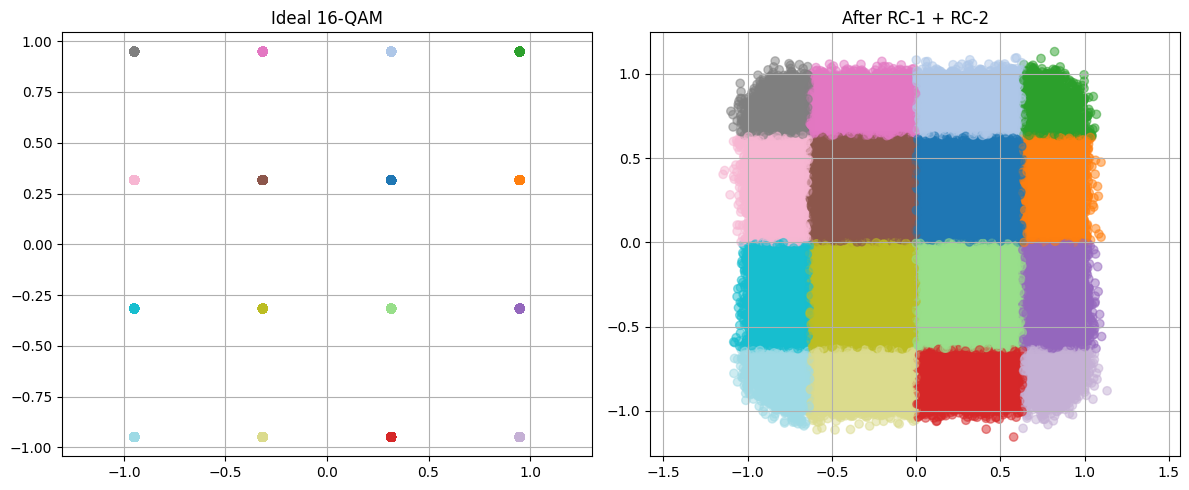

In [43]:
# ============ Block 7: Demap, Decode, Metrics =====================

from sionna.mapping import Demapper
from sionna.fec.ldpc.decoding import LDPC5GDecoder
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
num_bits_per_symbol = 4        # 16-QAM
demapper = Demapper(demapping_method="app",
                    constellation_type="qam",
                    num_bits_per_symbol=num_bits_per_symbol)

# ------------------------------------------------------------------
# Soft LLRs
c_hat = demapper([z_final, no])             # (64,768,4,4)

# Clip – avoid huge magnitudes
c_hat = tf.clip_by_value(c_hat, -10.0, 10.0)

# Reshape to (B,1,4,n)   (n = 3072 coded bits)
c_hat = tf.reshape(c_hat, [batch_size, 1, 4, -1])

# ------------------------------------------------------------------
# LDPC decoder (reuse same k,n as Block 2)
decoder = LDPC5GDecoder(encoder, num_iter=30, return_infobits=True)
b_hat   = tf.squeeze(decoder(c_hat), axis=1)     # (64,4,k)

# Ground-truth bits
b_true = tf.reshape(b, [batch_size, 4, -1])      # (64,4,k)

# ------------------------------------------------------------------
# Metrics
bit_errors   = tf.not_equal(b_true, b_hat)
ber  = tf.reduce_mean(tf.cast(bit_errors, tf.float32))


print("✅ Block 7 Complete — Metrics")
print(f"BER  : {ber.numpy():.6f}")


# ------------------------------------------------------------------
# Optional scatter plot
def hard_labels(z):
    pts = mapper.constellation.points                       # (16,) complex
    pts_ri = tf.stack([tf.math.real(pts), tf.math.imag(pts)], axis=-1)  # (16,2)
    z_ri   = tf.stack([tf.math.real(z),  tf.math.imag(z)],  axis=-1)    # (...,2)
    z_e    = tf.expand_dims(z_ri, -2)                       # (...,1,2)
    pts_e  = tf.reshape(pts_ri, [1,1,1,16,2])
    d2     = tf.reduce_sum(tf.square(z_e - pts_e), axis=-1) # (...,16)
    return tf.argmin(d2, axis=-1)                           # (...,)

z_true_np  = z_target.numpy()
z_final_np = z_final.numpy()

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(z_true_np.real.flatten(),
              z_true_np.imag.flatten(),
              c=hard_labels(z_true_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[0].set_title("Ideal 16-QAM"); ax[0].axis('equal'); ax[0].grid(True)

ax[1].scatter(z_final_np.real.flatten(),
              z_final_np.imag.flatten(),
              c=hard_labels(z_final_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[1].set_title("After RC-1 + RC-2"); ax[1].axis('equal'); ax[1].grid(True)

plt.tight_layout(); plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Use LLRs for the first bit (index 0) from c_hat
llr_bit0 = c_hat[:, :, :, 0].numpy().flatten()  # Shape: (64*768*4,)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Ideal constellation (same as before)
z_true_np = z_target.numpy()
ax[0].scatter(z_true_np.real.flatten(),
              z_true_np.imag.flatten(),
              c=hard_labels(z_true_np).numpy().flatten(),
              cmap='tab20', alpha=0.5)
ax[0].set_title("Ideal 16-QAM")
ax[0].axis('equal')
ax[0].grid(True)

# Estimated constellation with LLR-based coloring
z_final_np = z_final.numpy()
sc = ax[1].scatter(z_final_np.real.flatten(),
                   z_final_np.imag.flatten(),
                   c=llr_bit0,
                   cmap='RdBu',  # Red (LLR > 0) to Blue (LLR < 0)
                   alpha=0.5)
plt.colorbar(sc, ax=ax[1], label='LLR for Bit 0')
ax[1].set_title("After RC-1 + RC-2 (LLR-Colored)")
ax[1].axis('equal')
ax[1].grid(True)

plt.tight_layout()
plt.show()

NameError: name 'c_hat' is not defined

In [53]:
# ========= CNN Demapper =========================================
import tensorflow as tf, numpy as np, os
from tensorflow.keras import layers, models

# ---------- build ----------
def build_cnn(input_shape=(1064,8,2), filters=64, kernel=5, depth=4):
    x_in = layers.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], input_shape[1]*2))(x_in)   # (T,16)
    for _ in range(depth):
        x = layers.Conv1D(filters, kernel, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
    y = layers.Conv1D(8, 1, padding="same")(x)                    # (T,8)
    return models.Model(x_in, y, name="CNN_Demapper")

cnn = build_cnn()
phase_c  = tf.Variable(tf.zeros([768,4]), trainable=True)
amp_c    = tf.Variable(tf.ones([4]),       trainable=True)
opt_cnn  = tf.keras.optimizers.Adam(1e-3)
opt_pa_c = tf.keras.optimizers.Adam(1e-2)
λ = 5.0

def train_step_cnn(x_in, td_tgt, z_tgt):
    td_real = tf.cast(td_tgt, tf.float32)          # no cast warning
    with tf.GradientTape() as tape:
        y = cnn(x_in, training=True)               # (B,1064,8)
        y = tf.reshape(y, [batch_size,1064,4,2])
        y_c = tf.complex(y[...,0], y[...,1])
        wf   = tf.reduce_mean(tf.square(y - td_real))
        z_p  = tf.signal.fft(y_c)[:, :768, :]
        phase = tf.complex(tf.cos(phase_c), tf.sin(phase_c))
        z_c   = z_p * tf.expand_dims(phase,0) * \
                tf.cast(tf.reshape(amp_c,[1,1,4]), z_p.dtype)
        diff  = z_c - z_tgt
        qam   = tf.reduce_mean(tf.square(tf.math.real(diff)) +
                               tf.square(tf.math.imag(diff)))
        loss  = wf + λ*qam
    vars_all = cnn.trainable_variables + [phase_c, amp_c]
    grads    = tape.gradient(loss, vars_all)
    n = len(cnn.trainable_variables)
    opt_cnn.apply_gradients(zip(grads[:n], vars_all[:n]))
    opt_pa_c.apply_gradients(zip(grads[n:], vars_all[n:]))
    return qam

EPOCHS = 200
for ep in range(1,EPOCHS+1):
    q = train_step_cnn(x_input_rc1, teacher_td, z_target_r)
    if ep%5==0:
        print(f"Epoch {ep:02d} | CNN QAM loss {q:.4f}")

# ---------- constellation ----------
def get_cnn_constellation(x_in):
    y = cnn(x_in, training=False)
    y = tf.reshape(y, [batch_size,1064,4,2])
    z = tf.signal.fft(tf.complex(y[...,0], y[...,1]))[:, :768, :]
    p = tf.complex(tf.cos(phase_c), tf.sin(phase_c))
    return z * tf.expand_dims(p,0) * tf.cast(tf.reshape(amp_c,[1,1,4]), z.dtype)

z_corr_cnn = get_cnn_constellation(x_input_rc1)
np.save('z_cnn.npy', z_corr_cnn.numpy())
print("✅ CNN constellation saved  ➜  z_cnn.npy")


Epoch 05 | CNN QAM loss 7.7405
Epoch 10 | CNN QAM loss 4.5437
Epoch 15 | CNN QAM loss 3.0457
Epoch 20 | CNN QAM loss 2.2366
Epoch 25 | CNN QAM loss 1.7851
Epoch 30 | CNN QAM loss 1.5255
Epoch 35 | CNN QAM loss 1.3644
Epoch 40 | CNN QAM loss 1.2606
Epoch 45 | CNN QAM loss 1.1948
Epoch 50 | CNN QAM loss 1.1507
Epoch 55 | CNN QAM loss 1.1198
Epoch 60 | CNN QAM loss 1.0976
Epoch 65 | CNN QAM loss 1.0809
Epoch 70 | CNN QAM loss 1.0679
Epoch 75 | CNN QAM loss 1.0576
Epoch 80 | CNN QAM loss 1.0493
Epoch 85 | CNN QAM loss 1.0425
Epoch 90 | CNN QAM loss 1.0367
Epoch 95 | CNN QAM loss 1.0318
Epoch 100 | CNN QAM loss 1.0276
Epoch 105 | CNN QAM loss 1.0240
Epoch 110 | CNN QAM loss 1.0208
Epoch 115 | CNN QAM loss 1.0180
Epoch 120 | CNN QAM loss 1.0155
Epoch 125 | CNN QAM loss 1.0132
Epoch 130 | CNN QAM loss 1.0112
Epoch 135 | CNN QAM loss 1.0093
Epoch 140 | CNN QAM loss 1.0076
Epoch 145 | CNN QAM loss 1.0061
Epoch 150 | CNN QAM loss 1.0046
Epoch 155 | CNN QAM loss 1.0033
Epoch 160 | CNN QAM loss 1.

In [ ]:

import tensorflow as tf, numpy as np
from tensorflow.keras import layers, models, regularizers

# ---------- architecture ------------------------------------------
def build_cnn_medium(input_shape=(1064,8,2),
                     base_filters=96,       # more than 64, less than 128
                     blocks=5,              # conv-BN-ReLU × blocks
                     kernel_size=5,
                     dropout_rate=0.1):
    x_in = layers.Input(shape=input_shape)                    # (T,8,2)
    x    = layers.Reshape((input_shape[0], input_shape[1]*2))(x_in)   # (T,16)
    for i in range(blocks):
        f = base_filters if i < blocks-1 else base_filters//2
        x = layers.Conv1D(f, kernel_size, padding="same",
                          kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    # final 8-channel linear head
    y = layers.Conv1D(8, 1, padding="same")(x)                # (T,8)
    return models.Model(x_in, y, name="CNN_Medium")

cnnM = build_cnn_medium()
cnnM.summary()

# ---------- phase + amplitude correction ---------------------------
phaseM = tf.Variable(tf.zeros([768,4]), trainable=True)
ampM   = tf.Variable(tf.ones([4]),       trainable=True)

λ = 8.0                                # a bit stronger than before
opt_net  = tf.keras.optimizers.Adam(3e-4)
opt_pa   = tf.keras.optimizers.Adam(3e-3)

def train_step_cnnM(x_in, td_tgt, z_tgt):
    td_real = tf.cast(td_tgt, tf.float32)
    with tf.GradientTape() as tape:
        y = cnnM(x_in, training=True)                      # (B,1064,8)
        y = tf.reshape(y, [batch_size,1064,4,2])
        y_c = tf.complex(y[...,0], y[...,1])

        wf_loss = tf.reduce_mean(tf.square(y - td_real))

        z_pred  = tf.signal.fft(y_c)[:, :768, :]
        phase   = tf.complex(tf.cos(phaseM), tf.sin(phaseM))
        z_corr  = z_pred * tf.expand_dims(phase,0) * \
                  tf.cast(tf.reshape(ampM,[1,1,4]), z_pred.dtype)

        diff  = z_corr - z_tgt
        qam_loss = tf.reduce_mean(
                     tf.square(tf.math.real(diff)) +
                     tf.square(tf.math.imag(diff)))
        loss = wf_loss + λ*qam_loss

    vars_all = cnnM.trainable_variables + [phaseM, ampM]
    grads = tape.gradient(loss, vars_all)
    n_net = len(cnnM.trainable_variables)
    opt_net.apply_gradients(zip(grads[:n_net], vars_all[:n_net]))
    opt_pa.apply_gradients(zip(grads[n_net:], vars_all[n_net:]))
    return qam_loss.numpy()

# ---------- training loop ------------------------------------------
EPOCHS = 60
for ep in range(1, EPOCHS+1):
    q = train_step_cnnM(x_input_rc1, teacher_td, z_target_r)
    if ep % 5 == 0:
        print(f"Ep {ep:03d} | CNN-M QAM loss {q:.4f}")

# ---------- constellation output -----------------------------------
def cnnM_constellation(x_in):
    y = cnnM(x_in, training=False)
    y = tf.reshape(y, [batch_size,1064,4,2])
    z = tf.signal.fft(tf.complex(y[...,0], y[...,1]))[:, :768, :]
    p = tf.complex(tf.cos(phaseM), tf.sin(phaseM))
    return z * tf.expand_dims(p,0) * tf.cast(tf.reshape(ampM,[1,1,4]), z.dtype)

z_corr_cnnM = cnnM_constellation(x_input_rc1)
np.save('.npy', z_corr_cnnM.numpy())
print("✅ CNN constellation saved → z_cnn_medium.npy")


Model: "CNN_Medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1064, 8, 2)]      0         
                                                                 
 reshape_6 (Reshape)         (None, 1064, 16)          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 1064, 96)          7776      
                                                                 
 batch_normalization_16 (Ba  (None, 1064, 96)          384       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 1064, 96)          0         
                                                                 
 dropout (Dropout)           (None, 1064, 96)          0         
                                                        

In [ ]:

z_esn = z_final          # (64,768,4)

# medium CNN
z_cnnM = z_corr_cnnM     # (64,768,4)

# feed either tensor into your demapper/decoder block:
for tag, z in [("ESN", z_esn), ("CNN-M", z_cnnM)]:
    llr = demapper([z, no])
    llr = tf.clip_by_value(llr, -10., 10.)
    llr = tf.reshape(llr, [batch_size,1,4,-1])
    b_hat = tf.squeeze(decoder(llr), axis=1)
    ber = tf.reduce_mean(tf.cast(tf.not_equal(
              b_hat, tf.reshape(b, [batch_size,4,-1])), tf.float32)).numpy()
    print(f"{tag:5s} BER @ 10 dB : {ber:.3e}")


ESN   BER @ 10 dB : 2.679e-01
CNN-M BER @ 10 dB : 4.995e-01
